# Main Goal: Understanding the U Net Working for the Segmentation 

- Input: taking only 30 samples of input images and corresponding output masks (very small input set) from 2018 Data Science Bowl (https://www.kaggle.com/c/data-science-bowl-2018/data) Data.
- note that single input sample/folder consists of multiple input images for them there will be one multiplt corresponding masks
- Keras is used for the implementation 
     - To see how to install Keras please refer this link: https://limitlessdatascience.wordpress.com/2019/07/28/installation-steps-for-3-important-deep-learning-packages/
date: 26/4/2019

## U - Net Architecture (Example) diagram

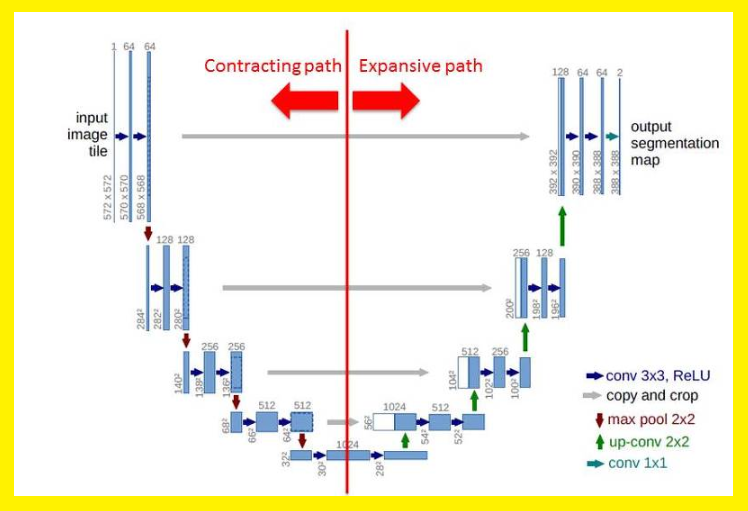

In [2]:
import PIL.Image as Image
Image.open("U Net Architecture.png")

#### U-Net Archtecture Consists of:
1. Downsampling path: a contracting path (left side)
2. Bottleneck 
3. Upsampling path: an expansive path (right side).

### Input data 2018 Data Science Bowl (https://www.kaggle.com/c/data-science-bowl-2018/data):
This dataset contains a large number of segmented nuclei images. The images were acquired under a variety of conditions and vary in the cell type, magnification, and imaging modality (brightfield vs. fluorescence).
- Each image is represented by an associated ImageId. Files belonging to an image are contained in a folder with this ImageId. Within this folder are two subfolders: 
    - images contains the image file.
    - masks contains the segmented masks of each nucleus. This folder is only included in the training set. Each mask contains one nucleus. Masks are not allowed to overlap (no pixel belongs to two masks).
    
Note: As with any human-annotated dataset, you may find various forms of errors in the data. You may manually correct errors you find in the training set. 

File descriptions
1. /stage1_train/* - training set images (images and annotated masks)
2. /stage1_test/* - stage 1 test set images (images only, you are predicting the masks)
3. /stage2_test/* (released later) - stage 2 test set images (images only, you are predicting the masks)

#### Note that a single image consists of different number of nuclei and for each nucleas they have provided a mask e.g. in 1st input image we have 70 masks. we will combine masks into single mask/map image. Hence we will predict only one image to simply the task 

### Output: is one class i.e. Nucleus(segmented) and a background which is black

# After installing data in zip format we will unzip it in the current working directory first

import subprocess   # Not needed to install seperately

CurrentDirectoryPath = subprocess.getoutput("pwd")  #Get current directory path by running command line and storing its 
#output in CurrentDirectoryPath

from pyunpack import Archive
Archive(path+'Data.zip').extractall(path)

In [18]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

#import warnings   # ignore the warnings
#warnings.filterwarnings("ignore", message=" ")  # ignore the warnings

%matplotlib inline

In [8]:
import subprocess   # Not needed to install seperately
path = subprocess.getoutput("pwd")  #Get current directory path by running command line and storing its 
#output in CurrentDirectoryPath

inputPath = path+'/Input/'  # input data is in the Input directory/folder

In [9]:
## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

#WHY RANDOM SEEDING IS USED?
#fix random seed for reproducibility:
Whenever we work with machine learning algorithms that use a stochastic process (e.g. random numbers), it is a good idea to set the random number seed.

This is so that you can run the same code again and again and get the same result. This is useful if you need to demonstrate a result, compare algorithms using the same source of randomness or to debug a part of your code.
link:https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

# Data Generator
- As our system may not handle these images at once therefore we will load them in a batch 

#### WHAT IS GENERATOR IN KERAS?

generator: A generator or an instance of Sequence (keras.utils.Sequence) object in order to avoid duplicate data when using multiprocessing. The output of the generator must be either 
1. a tuple (inputs, targets)
2. a tuple (inputs, targets, sample_weights).

This tuple (a single output of the generator) makes a single batch. Therefore, all arrays in this tuple must have the same length (equal to the size of this batch). Different batches may have different sizes. For example, the last batch of the epoch is commonly smaller than the others, if the size of the dataset is not divisible by the batch size. The generator is expected to loop over its data indefinitely. An epoch finishes when steps_per_epoch batches have been seen by the model.

#### fit command in keras:
When we start training after compilation we use this command in keras:
fit_generator(generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None, validation_data=None, validation_steps=None, validation_freq=1, class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0)

source: https://keras.io/models/sequential/#fit_generator

#### keras.utils.Sequence():
Base object for fitting to a sequence of data, such as a dataset. Every Sequence must implement  the __getitem__ and the __len__ methods. If you want to modify your dataset between epochs you may implement on_epoch_end. 

The method __getitem__ should return a complete batch. Sequence are a safer way to do multiprocessing. This structure guarantees that the network will only train once on each sample per epoch which is not the case with generators.
source: https://keras.io/utils/

In [10]:
class DataGen(keras.utils.Sequence):
    
    # Constructors: 
    def __init__(self, ids, path, batch_size=8, image_size=128): #initialising an image during training and testing as well
        
        #NOTE: In actual model we can see input image size is 572 x 572 x 1 but here we have 128 x 128 x3
        
        self.ids = ids    #these can be list of training or test ids. ids are the name of the image folders
        self.path = path  #can be either train or test folder path
        self.batch_size = batch_size   #default value 8 is taken
        self.image_size = image_size    # as we are resizing all the images and the masks into a same size (specified as 128) 
        self.on_epoch_end()
        
    #Function to load the corresponding image and masks using corresponding id_name. 
    #Will load single image and single mask(by combining segmentated maps) using a single image/folder id
    def __load__(self, id_name):
        ## Specifying Image Path:
        temp_id = os.path.split(id_name)[1]
        print('\nid_name=', temp_id)
        image_path = id_name + "/images/" + temp_id + ".png"
        
        #e.g. path = /home/training/, id_name = 1 then o/p of this line is: /home/training/1/images/1.png
             
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)  # list of all the mask names
        
        
        ## Reading Image
        image = cv2.imread(image_path, 1)  # 1 indicates reading in RGB format
        print('Image shape:', image.shape)

        image = cv2.resize(image, (self.image_size, self.image_size)) # resize the images into 128 x 128 
        mask = np.zeros((self.image_size, self.image_size, 1)) #array with all values as 0 & 128x 128
        #It will hold combined segmented img. 
        #it is going to be binary segmentation with 1 class. You can say 2 class if considered background and a nucleas
        
        ## Reading Masks/segmented maps and combining them into one map/segmented image
        for name in all_masks:
            _mask_path = mask_path + name  #individual mask path
            _mask_image = cv2.imread(_mask_path, -1)   #-1 indicates grayscale format
            print('mask:', _mask_image.shape)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #resizing image to 128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1) #adding one dimention i.e. channel 128 x 128 x 1
            
            mask = np.maximum(mask, _mask_image) #takes max value from mask and _mask_image and add them. 
            #Max value will be 255 because nucleas is white. All the nucleauses will be in the single image
        
        print('Combining & resizing done. Output mask shape is:', mask.shape, '\n& image shape:', image.shape)
        
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        
        # NOTE: in the actual model we dont have any normalization mentioned. May be its one of the assumption that is not mentioned in the paper
        
        return image, mask
    
    #__getitem__ function: return a complete batch. (COMPULSORY FUNCTION 1 in utils.Sequence)
    #here we are creating batches of the dataset. Therefore system will handle one batch at a time instead of whole dataset at once
    def __getitem__(self, index):                        
        print('index:', index)   #e.g. index is 0, batch_size = 2
        
        #condition check whether its a last batch or not? it can have less number of 
        if(index+1)*self.batch_size > len(self.ids):    #self.ids = list of images in the training/testing dataset=4
            #if batch size is 2 and we have 4 input images in training/testing set then
            #divide this set into 2 sets of 2 images each  
            self.batch_size = len(self.ids) - index*self.batch_size  
       
     #   print('self.batch_size =', self.batch_size)
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]  # take name of the files = batch_size
        
      #  print('files_batch', len(files_batch), files_batch)
        
        image = []
        mask  = []
        print('Loading image and masks for path and id_name as:')
        for id_name in files_batch:
       #     print('id_name:', id_name)
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):  # ????
        pass
    
    def __len__(self):      # (COMPULSORY FUNCTION 2 in utils.Sequence)
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

#### Study the the ImageDataGenerator class provided by Keras:
The main benefit of using this class to load the data is that images are loaded for a single dataset in batches, meaning that it can be used for loading both small datasets as well as very large image datasets with thousands or millions of images.

Instead of loading all images into memory, it will load just enough images into memory for the current and perhaps the next few mini-batches when training and evaluating a deep learning model. I refer to this as progressive loading, as the dataset is progressively loaded from file, retrieving just enough data for what is needed immediately.

Two additional benefits of the using the ImageDataGenerator class is that it can also automatically scale pixel values of images and it can automatically generate augmented versions of images. We will leave these topics for discussion in another tutorial and instead focus on how to use the ImageDataGenerator class to load image data from file.
source: https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/

# Hyperparameters¶

In [ ]:
image_size = 128
#train_path = "dataset/stage1_train/"

train_path = inputPath

#epochs = 500  taken for 6 inputs #with increase in number of epochs accuracy in testing increased tremendously

epochs = 100  # for 30 inputs

batch_size = 2  # in keras batch size should be always less than the number of training dataset 
# by default it will be 8

## Training Ids
#train_ids = next(os.walk(train_path))[1]
import glob
train_ids = glob.glob(train_path+'*')
print('Train Ids on the file are:', train_ids)

## Validation Data Size
val_data_size = 6

In [ ]:
# Now divide training dataset into training and validation datasets
valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]
print('Training data:\n', train_ids)
print('Validation data:\n', valid_ids)

In [13]:
#testing DataGen class and functions init
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)  # getitem will create batches of input dataset. e.g. if len(train_ids) = 6 and batch_size = 2 then
#gen.__getitem__(0): return 1st batch of 2 input imgs i.e. x1, x2 and 2 corresponding output images i.e. y1, y2
#gen.__getitem__(1): return 2nd batch of 2 input imgs i.e. x3, x4 and 2 corresponding output images i.e. y3, y4
#gen.__getitem__(2): return 3rd batch of 2 input imgs i.e. x5, x6 and 2 corresponding output images i.e. y5, y6

index: 0
Loading image and masks for path and id_name as:

id_name= 0c6507d493bf79b2ba248c5cca3d14df8b67328b89efa5f4a32f97a06a88c92c
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1c2f9e121fc207efff79d46390df1a740566b683ff56a96d8cabe830a398dd2e
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)

In [14]:
print(x.shape, y.shape)    # one batch of training dataset returned from DataGen

(2, 128, 128, 3) (2, 128, 128, 1)


### About Input data:
- Input images shapes: there are 3 images with (256, 256, 3) & one image is (256, 320, 3) and Shape of the masks is same as the the input images
- Input is image with 3 channels i.e. RGB and Output is 1 channel i.e. Gray scale

# Data 

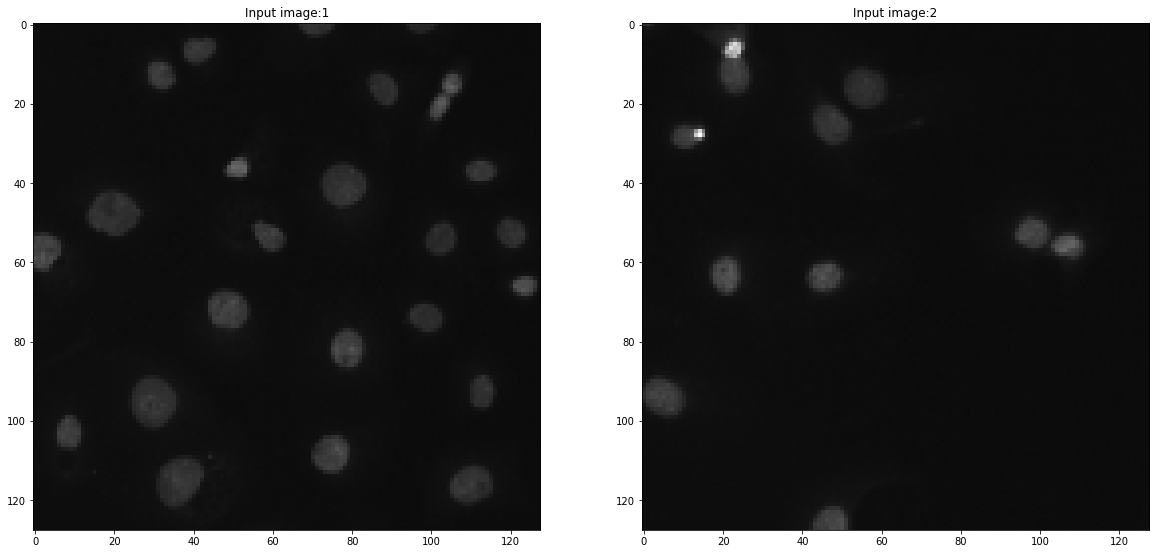

In [15]:
fig=plt.figure(figsize=(20, 20))
columns = 2
rows = x.shape[0]-1

i = 0
while i <= rows:
    img= x[i]      #Since my arrays 1st location 0
    
    fig.add_subplot(rows, columns, i+1)                     #Here starting should be from i = 1 for 0 it will show an error
    plt.title('Input image:{}'.format(i+1))
    plt.imshow(img, cmap = plt.cm.bone)
    i = i + 1
plt.show()

### Corresponding Output data batch:

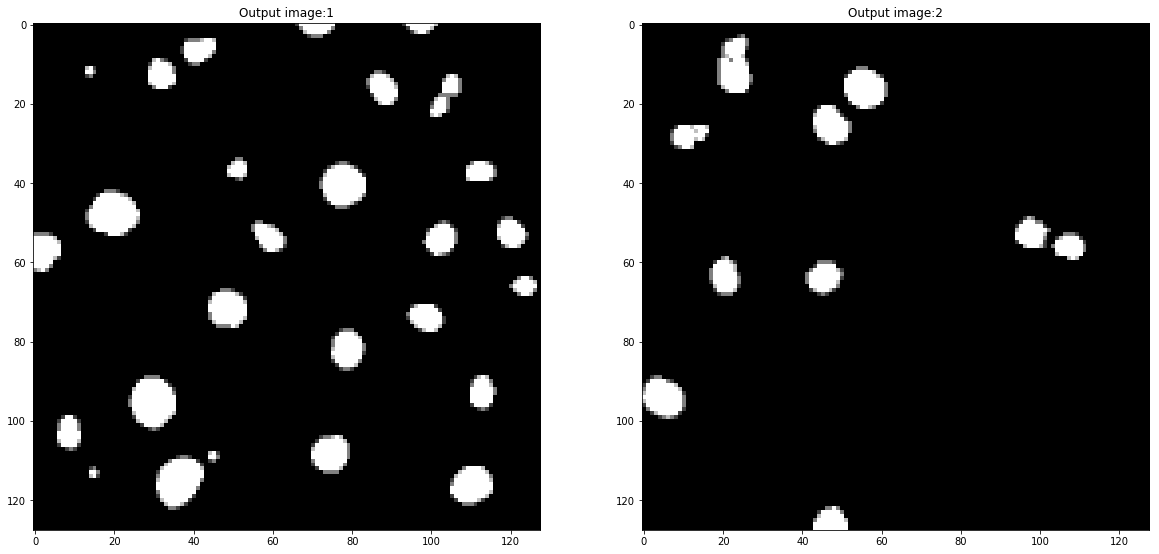

In [19]:
fig=plt.figure(figsize=(20, 20))
columns = 2
rows = y.shape[0]-1
i = 0
while i <= rows:
    img= y[i]      #Since my arrays 1st location 0
    fig.add_subplot(rows, columns, i+1)                     #Here starting should be from i = 1 for 0 it will show an error
    plt.title('Output image:{}'.format(i+1))
    plt.imshow(np.reshape(img, (image_size, image_size)), cmap="gray")
    i = i + 1
plt.show()

### One sample input and corresponding combined segmented output image in the batch

r is 0


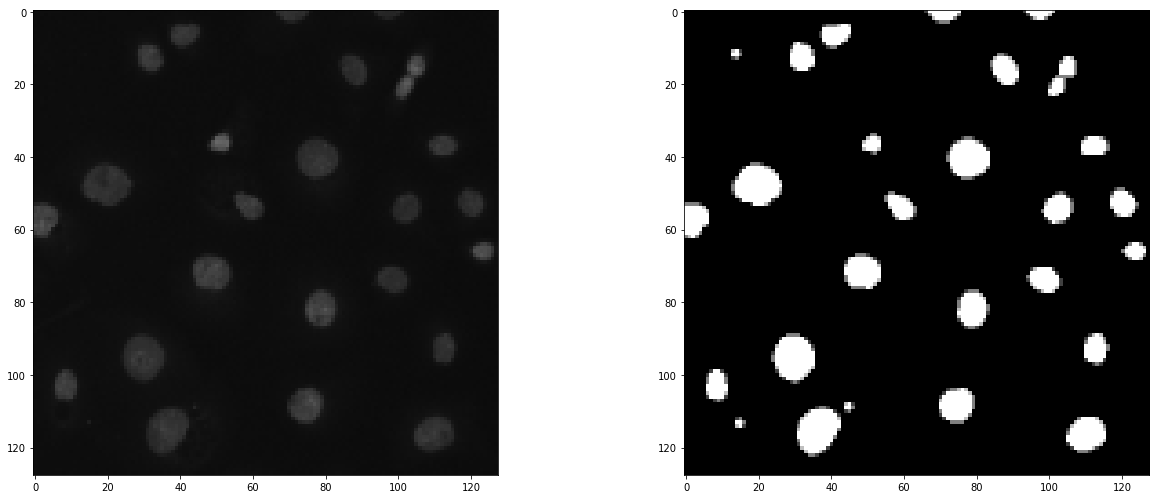

In [20]:
r = random.randint(0, len(x)-1)
print('r is', r)
fig = plt.figure()
fig=plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

### Note that: 
input is black and white as well as in colour. Some input images are blackwhite and some are black and white

# Different Convolutional Blocks

#### Downsampling Path: 
The contracting path follows the typical architecture of a convolutional network. It consists of:
1. the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling.
2. At each downsampling step we double the number of feature channels.

In [21]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    #the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c) #2x2 max pooling operation with stride 2 for downsampling
    return c, p

#### Upsampling path:
- Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. 
- The cropping is necessary due to the loss of border pixels in every convolution. 
- Slip connection: The skip connection from the downsampling path are concatenated with feature map during upsampling path. These skip connections provide local information to global information while upsampling.

In [22]:
def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [23]:
def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

# UNet Model

In [24]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    #### Final Layer:
    #At the final layer a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. 
    #In total the network has 23 convolutional layers.

    model = keras.models.Model(inputs, outputs)
    return model

In [27]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"]) # Compile model
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 128, 128, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_38[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_39[0][0]                  
____________________________________________________________________________________________

### Error or Loss Function: A loss function (or objective function, or optimization score function) is one of the two parameters required to compile a model:
- Note: when using the categorical_crossentropy loss, your targets should be in categorical format (e.g. if you have 10 classes, the target for each sample should be a 10-dimensional vector that is all-zeros except for a 1 at the index corresponding to the class of the sample). In order to convert integer targets into categorical targets, you can use the Keras utility to_categorical:

from keras.utils import to_categorical

categorical_labels = to_categorical(int_labels, num_classes=None)
When using the sparse_categorical_crossentropy loss, your targets should be integer targets. If you have categorical targets, you should use categorical_crossentropy.

# Training the model

#traying out simple keras model execution
train_steps = len(x)//batch_size
print('training steps are:', train_steps)
model.fit_generator(x, y, epochs=epochs)

In [28]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size
print('Validation dataset names:', len(valid_ids))
print('training dataset names:', len(train_ids))
print(batch_size, train_steps, valid_steps)
#if btach_size is 2, training dataset size is 6 (hence 3 batches each having: 2 imgs), 
#validation dataset size is 2 (hence 1 batch 2 imgs). To train a model on training dataset 
#it will take 3 steps and for validation it will take one step

Validation dataset names: 6
training dataset names: 24
2 12 3


In [29]:
%time model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,epochs=epochs)

index: 2
Loading image and masks for path and id_name as:

id_name= 0acd2c223d300ea55d0546797713851e818e5c697d073b7f4091b96ce0f3d2fe
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5
Image shape: (520, 696, 3)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)

mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 0d3640c1f1b80f24e94cc9a5f3e1d9e8db7bf6af7d4aba920265f46cadc25e37
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 1
Loadin

11/12 [==========================>...] - ETA: 0s - loss: 0.6510 - acc: 0.8265index: 6
Loading image and masks for path and id_name as:

id_name= 0c2550a23b8a0f29a7575de8c61690d3c31bc897dd5ba66caec201d201a278c2
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(520, 696)

mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask: (520, 696) 
(256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 7mask:
 Loading image and masks for path and id_name as:(520, 696)


id_name=Combining & resizing done. Output mask shape is:  0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3(128, 128, 1)
 
& image shape: (128, 128, 3)

id_name= 0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1
Image shape: (256, 320, 3)
m

mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: 

mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1bd0f2b3000b7c7723f25335fabfcdddcdf4595dd7de1b142d52bb7a186885f0mask:
 (520, 696)
mask: (520, 696)
mask:Image shape: (520, 696)
 (360, 360, 3)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 2
Loading image and masks for path and id_name as:

id_name=mask:  0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0(360, 360)

mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: Image shape:(360, 360) 
(256, 256, 3)mask:
 mask:(360, 360) 
(256, 256)mask:
 mask:(360, 360) 
(256, 256)mask:
 mask:(360, 360) 
(256, 256)mask:
 mask:(360, 360) 
(256, 256)mask:
 mask:(360, 360) 
(256, 256)mask:
 mask:(360, 360) 
(256, 256)mask:
 (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (3

Image shape: (1024, 1024, 3)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
index: 0
Loading image and masks for path and id_name as:

id_name= 0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6
mask: (1024, 1024)
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: mask:(1024, 1024) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (12

mask: (520, 696)
mask: (360, 360)
mask: mask:(360, 360) 
(520, 696)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask:mask:  (520, 696)(360, 360)

mask: (360, 360)
mask: mask:(520, 696) 
(360, 360)
mask: (360, 360)
mask: (520, 696)mask:
 (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: mask:(520, 696) 
(360, 360)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 8
mask:Loading image and masks for path and id_name as: 
(520, 696)
id_name=
 0ddd8deaf1696db68b00c600601c6a74a0502caaf274222c8367bdc31458ae7e
mask: (520, 696)Image shape:
 (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)

mask: mask:(256, 320) 
(256, 256)mask:
 (256, 320)
mask:mask:  (256, 320)(256, 256)

mask: mask:(256, 256) 
(256, 320)
mask:mask:  (256, 320)(256, 256)

mask:mask:  (256, 256)(256, 320)

mask: (256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
mask: (256, 256)
mask: (256, 256)(256, 320)

mask:mask:  (256, 256)(256, 320)

mask:Combining & resizing done. Output mask shape is: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256) 
(128, 128, 1)mask:  (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
& image shape:
 mask:(128, 128, 3) 
(256, 256)
id_name=
 mask:0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9 
(256, 256)Image shape:
 mask:(256, 256, 3) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 (256, 256)mask:
 mask:(256, 256) 


mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 7
Loading image and masks for path and id_name as:

id_name= 0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)

mask:mask: (520, 696) 
(1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask: (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)

mask:mask:  (256, 320)(520, 696)

mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: mask:(256, 320) 
mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 256, 3)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: 

 (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: (520, 696)
mask: (520, 696)
mask: (256, 256)
mask: mask: (520, 696)
(256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1c2f9e121fc207efff79d46390df1a740566b683ff56a96d8cabe830a398dd2emask:
 (520, 696)
mask: (520, 696)
Image shape: (256, 256, 3)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask:mask: (520, 696) 
(256, 256)mask: (520, 696)

mask: (256, 256)
mask:mask:  (256, 256)
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape 

Image shape: (1024, 1024, 3)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
index: 0
Loading image and masks for path and id_name as:

id_name= 0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6
mask: (1024, 1024)
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)Combining & resizing done. Output 

Image shape: mask: (520, 696)(520, 696, 3)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(520, 696)
mask: (520, 696)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (520, 696)
mask:mask: (520, 696) 
(520, 696)
mask: mask:(520, 696) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: mask:(1024, 1024, 3) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (102

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: 2/12 [====>.........................]  - ETA: 3s - loss: 0.3739 - acc: 0.8670(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask:

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Image shape: (520, 696, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(520, 696)

Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask: (520, 696)
index: 3
Loading image and masks for path and id_name as:

id_name= 1c681dfa5cf7e413305d2e90ee47553a46e29cce4f6ed034c8297e511714f867
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 256, 3)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: 

mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask: (520, 696)(256, 256)

Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1c2f9e121fc207efff79d46390df1a740566b683ff56a96d8cabe830a398dd2e
mask: (520, 696)
mask:Image shape:  (520, 696)(256, 256, 3)

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask:mask: (256, 256)
 (520, 696)
mask: (256, 256)
Combin

mask: (256, 256)mask: (1024, 1024)
mask: 
(1024, 1024)mask: (256, 256)
mask: 
(256, 256)
mask:mask:  (256, 256)(1024, 1024)

mask:mask:  (256, 256)(1024, 1024)

mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180
mask: (1024, 1024)
Image shape: (520, 696, 3)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520

mask: (520, 696)
mask: (520, 696)
mask: mask: (256, 320)
mask: (256, 320)
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask:mask:  (520, 696)(256, 320)

mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is:mask: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 0d3640c1f1b80f24e94cc9a5f3e1d9e8db7bf6af7d4aba920265f46cadc25e37
 (520, 696)Image shape:
 mask:(256, 320, 3) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: mask: (256, 320)(520, 696)
mask: (520, 696)

mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (520, 696)
mask: (256, 320)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask:mask: (256, 320)
 (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: 

mask: (256, 256)index:
 mask:0
 Loading image and masks for path and id_name as:(256, 256)


id_name=Combining & resizing done. Output mask shape is:  0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6(128, 128, 1)
 
& image shape: (128, 128, 3)
index: 9
Loading image and masks for path and id_name as:

id_name= 0e5edb072788c7b1da8829b02a49ba25668b09f7201cf2b70b111fc3b853d14f
Image shape: (256, 256, 3)
Image shape: (256, 320, 3)mask:
 (256, 256)
mask: mask:(256, 320) 
(256, 256)
mask: (256, 256)
mask: (256, 320)
mask: (256, 256)
mask: (256, 320)
mask: (256, 256)
mask: (256, 320)
mask: (256, 256)
mask: (256, 320)
mask: (256, 256)
mask: (256, 320)mask:
 (256, 256)
mask: (256, 320)
mask: (256, 256)
mask: (256, 320)
mask: (256, 256)
mask: (256, 320)mask:
 (256, 256)
mask: (256, 320)
mask: (256, 256)
mask: (256, 320)mask:
 (256, 256)
mask: mask:(256, 256) 
(256, 320)
mask: (256, 256)mask:
 (256, 320)
mask: (256, 256)
mask: (256, 320)
mask: (256, 256)
mask: mask:(256, 256) 
(25

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)

 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)
mask:mask:  (256, 256)(256, 320)

mask:mask:  (256, 256)(256, 320)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)
(256, 320)
mask: (256, 256)
mask:mask:  (256, 256)(256, 320)

mask:mask:  (256, 256)(256, 320)

mask:mask:  (256, 256)(256, 320)

mask:mask:  (256, 256)(256, 320)

mask:mask:  (256, 256)(256, 320)

mask:mask:  (256, 256)(256, 320)

mask:mask:  (256, 2

mask: (520, 696)
mask: (520, 696)
Epoch 7/100
index: mask:11
Loading image and masks for path and id_name as:

id_name= 1b2bf5933b0fb82918d278983bee66e9532b53807c3638efd9af66d20a2bae88
 Image shape:(520, 696) 
(256, 256, 3)mask:
 mask:(520, 696) 
(256, 256)mask:
 mask:(520, 696) 
(256, 256)mask:
 mask:(520, 696) 
(256, 256)mask:
 mask:(520, 696) 
(256, 256)mask:
 mask:(520, 696) 
(256, 256)mask:
 mask:(520, 696) 
(256, 256)mask:
 mask:(520, 696) 
(256, 256)mask:
 mask:(520, 696) 
(256, 256)mask:
 mask:(520, 696) 
(256, 256)mask:
mask:  (520, 696)(256, 256)

mask:mask:  (520, 696)(256, 256)

mask:Combining & resizing done. Output mask shape is:  (520, 696)(128, 128, 1)
 
& image shape: (128, 128, 3)

id_name= 1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 6

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
11/12 [==========================>...] - ETA: 0s - loss: 0.3639 - acc: 0.8306index: 3
Loading image and masks for path and id_name as:

id_name= 1c681dfa5cf7e413305d2e90ee47553a46e29cce4f6ed034c8297e511714f867
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (

mask: (520, 696)mask:
 (360, 360)
mask:mask:  (520, 696)(360, 360)

mask: (360, 360)
mask:mask: (520, 696) (360, 360)

mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: mask:(520, 696) 
(360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask: (520, 696)
index: 0
Loading image and masks for path and id_name as:

id_name= 0c6507d493bf79b2ba248c5cca3d14df8b67328b89efa5f4a32f97a06a88c92c
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 256, 3)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)

mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (1024, 1024, 3)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 69

Combining & resizing done. Output mask shape is: 
(128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 9
Loading image and masks for path and id_name as:

id_name= 0e5edb072788c7b1da8829b02a49ba25668b09f7201cf2b70b111fc3b853d14f
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Image shape: (520, 696, 3)mask: 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask: (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (

mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 69

mask:mask:  (520, 696)(1024, 1024)

mask:mask:  (520, 696)(1024, 1024)

mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: mask: (520, 696)
mask: (520, 696)
(1024, 1024)
mask: (520, 696)
mask:mask: (520, 696)
 mask: (520, 696)(1024, 1024)

mask: (520, 696)
mask: mask: (1024, 1024)(520, 696)

mask: mask:(520, 696) 
(1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)mask: (1024, 1024)
mask:
 (1024, 1024)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)
(520, 696)
mask: (520, 696)
mask:mask: (1024, 1024)
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1

mask: (256, 256)
mask: (256, 320)
mask: (256, 256)
mask: (256, 320)
mask: (256, 256)
mask: (256, 320)mask:
 (256, 256)
mask: (256, 320)
mask: (256, 256)
mask: (256, 256)
mask: (256, 320)
mask: (256, 256)
mask: (256, 320)
mask: (256, 256)
mask: (256, 320)mask:
 (256, 256)
mask: (256, 320)
mask: (256, 256)
mask: mask:(256, 256) 
(256, 320)
mask: (256, 256)
mask: (256, 320)
mask: (256, 256)
mask: (256, 320)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape:mask:  (128, 128, 3)(256, 320)

index: 5mask:
 Loading image and masks for path and id_name as:(256, 320)


id_name= 0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a3893a7d5835c85284132e
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1a75e9f15481d11084fe66bc2a5afac6dc5bec20ed56a7351a6d65ef0fe8762b
Image shape: (256, 320, 3)
mask: (256, 320)
mask: Image shape:(256, 320) 
(256,

mask: mask:(1024, 1024)
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)mask:
 (520, 696)
index: 9
Loading image and masks for path and id_name as:

id_name= mask:0e5edb072788c7b1da8829b02a49ba25668b09f7201cf2b70b111fc3b853d14f 
(520, 696)
mask: (520, 696)
Image shape: (256, 256, 3)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)m

mask:mask: (520, 696) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 69

mask:(520, 696) (256, 256)
mask: (256, 256)

mask: (256, 256)
mask: (256, 256)
mask:mask: (520, 696)
mask: (520, 696)
 (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: (520, 696)mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1)
 
& image shape: (128, 128, 3)
index:mask: (520, 696)
mask: (520, 696)
 4
Loading image and masks for path and id_name as:

id_name= 00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (256, 320)
mask: mask: (520, 696)(256, 320)

mask: (520, 696)
mask: (520, 696)
mask:mask: (256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: mask: (520, 696)
mask: (520, 696)
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask:mask:  (256, 320)
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask:

mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
index: 0
Loading image and masks for path and id_name as:

id_name= 0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6
mask: (1024, 1024)
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask:mask:  (102

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (1024, 1024, 3)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (5

mask:mask: (520, 696) 
(256, 256)mask:
 mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask: (256, 256) 
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 25

 
id_name=(256, 256) 
0b0d577159f0d6c266f360f7b8dfde46e16fa665138bf577ec3c6f9c70c0cd1emask:
 Image shape:(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 4
Loading image and masks for path and id_name as:

id_name= 00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
 (520, 696, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: mask: (520, 696)
(256, 320)
mask:mask:  (520, 696)(256, 320)

mask: mask: (520, 696)
mask:(256, 320)
 (520, 696)
mask: (256, 320)mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1

mask: (256, 320)
mask: 

mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 69

mask:mask:  (256, 256)(256, 256)

mask:mask:  (256, 256)(256, 256)

mask:mask:  (256, 256)(256, 256)

mask:mask:  (256, 256)(256, 256)

mask:mask:  (256, 256)(256, 256)

mask:mask:  (256, 256)(256, 256)

mask:mask:  (256, 256)
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(256, 256)

mask: (256, 256)
mask:mask:  (256, 256)(256, 256)

mask: (256, 256)
mask:mask:  (256, 256)(256, 256)

mask: (256, 256)
mask:mask:  (256, 256)(256, 256)

mask:Combining & resizing done. Output mask shape is:  (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)(128, 128, 1)
 mask:
& image shape:  (256, 256)(128, 128, 3)

mask:index:  (256, 256)3

mask:Loading image and masks for path and id_name as: 
(256, 256)
id_name=
 mask:1c681dfa5cf7e41330

  (520, 696)(1024, 1024)

Epoch 12/100mask:mask:
 (1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (1024, 1024)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask:

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
11/12 [==========================>...] - ETA: 0s - loss: 0.3041 - acc: 0.8575index: 9
Loading image and masks for path and id_name as:

id_name= 0e5edb072788c7b1da8829b02a49ba25668b09f7201cf2b70b111fc3b853d14f
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (

mask: (520, 696)mask: 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: Combining & resizing done. Output mask shape is: (128, 128, 1) (520, 696)
& image shape:
 (128, 128, 3)
index: 8
Loading image and masks for path and id_name as:

id_name= 0ddd8deaf1696db68b00c600601c6a74a0502caaf274222c8367bdc31458ae7e
mask: (520, 696)
Image shape: (256, 256, 3)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 

Combining & resizing done. Output mask shape is: (128, 128, 1)mask:  
& image shape:(520, 696)
 (128, 128, 3)

id_name= 1c2f9e121fc207efff79d46390df1a740566b683ff56a96d8cabe830a398dd2e
mask: (520, 696)
Image shape: (256, 256, 3)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: mask:7 
(520, 696)Loading image and masks for path and id_name as:


id_name= 0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (2

mask: (520, 696)mask:
mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (520, 69

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)

mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 25

mask:mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1)  (520, 696)
& image shape:
 (128, 128, 3)

id_name= 1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (520, 696, 3)
mask: (520, 696)
mask:mask:  (520, 696)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: 

mask:mask: (520, 696) 
(256, 320)mask:
 (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(256, 320)

mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: mask:(256, 320)
mask:  (256, 320)(520, 696)

mask:mask:  (256, 320)(520, 696)

mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask:mask:  (520, 696)(256, 320)

mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask:mask: (520, 696)
 (256, 320)mask: (520, 696)

mask: (256, 320)
mask:mask:  (520, 696)(256, 320)

mask: (520, 696)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
mask:  (520, 696)(256, 320)

mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask: (256, 320

Image shape: (1024, 1024, 3)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)index:
 0
Loading image and masks for path and id_name as:

id_name= 0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6
mask:Image shape:  (1024, 1024)(256, 320, 3)

mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1

mask:mask: (520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask:Combining & resizing done. Output mask shape is:  (520, 696)(128, 128, 1)
 
& image shape: (128, 128, 3)

id_name= 0d3640c1f1b80f24e94cc9a5f3e1d9e8db7bf6af7d4aba920265f46cadc25e37
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask: (520, 696)
index: 3
Loading image and masks

mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)mask:
 (102

mask:mask: (520, 696)
 mask: (256, 256)
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)mask: (520, 696)

mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256)
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) (520, 696)

mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (520, 696)
mask: (256, 256)
mask:mask:  (256, 256)
(520, 696)mask: 
(256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)mask:
 (520, 696)
mask:mask: (256, 256) (520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1c2f9e121fc207efff79d46390df1a740566b683ff56a96d8cabe830a398dd2e
mask: (520, 696)
mask: Image shape:(520, 696) 
(256, 256, 3)mask:
 mask:(520, 696) 
(256, 256)
mask:mask: 1/12 [=>....

mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 0a7d30b252359a10fd298b638b90cb

mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask:mask:  (520, 696)(256, 320)

mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)Combining & resizing done. Output mask shape is:
 (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 0d3640c1f1b80f24e94cc9a5f3e1d9e8db7bf6af7d4aba9

mask:mask: (1024, 1024) 
(520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)

Epoch 16/100
index: 7
Loading image and masks for path and id_name as:

id_name= 0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256,

mask: (520, 696)
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 5
Loading image and masks for path and id_name as:

id_name=mask:  0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a3893a7d5835c85284132e(520, 696)

mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: 

mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask: (1024, 1024)
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 69

mask: (256, 320)mask:
mask:  (520, 696)(256, 320)

mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask:Combining & resizing done. Output mask shape is:  (128, 128, 1)(520, 696) 

& image shape: (128, 128, 3)

id_name= 0d3640c1f1b80f24e94cc9a5f3e1d9e8db7bf6af7d4aba920265f46cadc25e37
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask:mask:  (520, 696)(256, 320)

mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: 

mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
index: 0
Loading image and masks for path and id_name as:

id_name= 0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6
mask: (1024, 1024)
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256

mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)

 (256, 256)mask:
 mask:(520, 696)
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (520, 696)mask: 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)
(256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is:mask: (520, 696) 
(128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1d02c4b5921e916b9ddfb2f741fd6cf8d0e571ad51eb20e021c826b5fb87350e
mask: (520, 696)
mask

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: mask:1
Loading image and masks for path and id_name as:
 
id_name= 0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93(520, 696)

mask: (520, 696)
mask:Image shape:  (520, 696)(256, 256, 3)

mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 0d2bf916cc8de90d02f4cd4c23ea79b227dbc45d845b4124ffea380c92d34c8c
mask: (520, 696)
Image shape: (360, 360, 3)
mask:mask: (360, 360)
mask: (360, 360)
 (520, 696)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask:mask:  (360, 360)(520, 696)

mask: (3

mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 32

mask:mask:  (256, 320)(520, 696)

Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask:mask: (256, 256)
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 mask:(256, 256) 
(520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 12

mask:mask: (1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 2mask: (1024, 1024)

Loading image and masks for path and id_name as:

id_name= 0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0
mask: (1024, 1024)
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (1024, 1024)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (1024, 1024)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (1024, 1024)
mask: (256, 256)
mask: (256, 256)
mask: (25

Epoch 19/100
Image shape: (520, 696, 3)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (5

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 9mask:
 Loading image and masks for path and id_name as:(520, 696)


id_name= 0e5edb072788c7b1da8829b02a49ba25668b09f7201cf2b70b111fc3b853d14f
mask: (520, 696)
Image shape: (256, 256, 3)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask: 
(520, 696)
mask: (256, 256)
mask

mask:mask:  (520, 696)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 69

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180
Image shape: (520, 696, 3)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: 

mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 0mask:
 Loading image and masks for path and id_name as:(520, 696)


id_name= 0c6507d493bf79b2ba248c5cca3d14df8b67328b89efa5f4a32f97a06a88c92c
mask: (520, 696)
Image shape: (256, 256, 3)
mask: (520, 696)
mask: (256, 256)
mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (256,

mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696)
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 69

mask:mask:  (360, 360)(520, 696)

mask: (360, 360)
mask: (520, 696)mask:
 (360, 360)
mask: (360, 360)
mask: mask:(360, 360) 
(520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: mask:(360, 360) 
(520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: mask:(360, 360) 
(520, 696)mask:
 (360, 360)
mask: (360, 360)
Combining & resizing done. Output mask shape is: (128, 128, 1)mask:  
& image shape:(520, 696) 
(128, 128, 3)
index: 5
Loading image and masks for path and id_name as:

id_name= 0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a3893a7d5835c85284132e
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 7
Loading image and masks for path and id_name as:

id_name= 0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)

mask:mask:  (256, 320)(520, 696)

mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 0d3640c1f1b80f24e94cc9a5f3e1d9e8db7bf6af7d4aba920265f46cadc25e37
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 11
Loading image and masks for path and id_name as:
mask:
id_name=  (520, 69

mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 0bda515e370294ed94efd36bd53782288acacb040c171df2ed97fd691fc9d8fe
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256
12/12 [==============================] - 4s 353ms/step - loss: 0.1702 - acc: 0.9226 - val_loss: 0.2467 - val_acc: 0.8615
mask: (256, 256)
mask:Epoch 22/100 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (25


Image shape: (256, 256, 3)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: Combining & resizing done. Output mask shape is:(256, 256) 
(128, 128, 1)mask:  
& image shape:(256, 256) 
(128, 128, 3)

id_name= 0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: Image shape: (256, 256)(520, 696, 3)

mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask: (520, 696)
index: 8
Loading image and masks for path and id_name as:

id_name= 0ddd

mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask: (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 69

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: Image shape:(520, 696) 
(1024, 1024, 3)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1

mask:mask:  (256, 256)(520, 696)

mask:mask:  (256, 256)(520, 696)

mask:mask:  (256, 256)(520, 696)

mask:mask:  (256, 256)(520, 696)

mask:Combining & resizing done. Output mask shape is:  (256, 256)(128, 128, 1)
 mask:
& image shape:  (256, 256)(128, 128, 3)

Combining & resizing done. Output mask shape is:
id_name=  (128, 128, 1)0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 

& image shape: (128, 128, 3)
index: 7
Loading image and masks for path and id_name as:

id_name= 0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3
Image shape: (520, 696, 3)
Image shape: (256, 320, 3)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (2

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)

mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)mask:
 (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1)mask:  
& image shape:(520, 696) 
(128, 128, 3)

id_name= 1bd0f2b3000b7c7723f25335fabfcdddcdf4595dd7de1b142d52bb7a186885f0
mask: (520, 696)
mask: (520, 696)
Image shape: (360, 360, 3)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& 

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 3
Loading image and masks for path and id_name as:

id_name= 1c681dfa5cf7e413305d2e90ee47553a46e29cce4f6ed034c8297e511714f867
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)

mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)Combining & resizing done. Output mask shape is:
 (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1bd0f2b3000b7c7723f25335fabfcdddcdf4595dd7de1b142d52bb7a186885f0
mask: (520, 696)
mask: (520, 696)
Image shape: (360, 360, 3)
mask: (520, 696)
mask: (360, 3

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (1024, 1024, 3)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 

Image shape: (256, 256, 3)Epoch 25/100

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128,

mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 0d3640c1f1b80f24e94cc9a5f3e1d9e8db7bf6af7d4aba9

mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 69

mask: (256, 256)mask:
mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask:index:  (520, 696)7

Loading image and masks for path and id_name as:

id_name= 0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (520, 696)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)

mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
 1/12 [=>............................]mask: - ETA: 3s - loss: 0.0718 - acc: 0.9682 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 69

Image shape: (520, 696, 3)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)index:
 0
Loading image and masks for path and id_name as:

id_name= 0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 32

mask:mask:  (520, 696)(256, 320)

mask: (256, 320)
mask:mask:  (256, 320)(520, 696)

mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask:Combining & resizing done. Output mask shape is:  (520, 696)(128, 128, 1)
 
& image shape: (128, 128, 3)

id_name= 0d3640c1f1b80f24e94cc9a5f3e1d9e8db7bf6af7d4aba920265f46cadc25e37
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask:mask:  (256, 320)(520, 696)

mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
Combining & resizing do

 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)Combining & resizing done. Output mask shape is:
 mask:(128, 128, 1)  (256, 256)
& image shape:
 mask:(128, 128, 3) 
(256, 256)index:
 mask:10 
Loading image and masks for path and id_name as:(256, 256)


id_name=mask:  1a75de9e11303142864efed27e69ea1960dbd82ca910de221a777ed2caf35a6b(256, 256)

Image shape:mask:  (360, 360, 3)(256, 256)

mask:mask:  (360, 360)(256, 256)

mask:mask:  (360, 360)(256, 256)

mask:mask:  (360, 360)(256, 256)

mask:mask:  (360, 360)(256, 256)

mask:mask:  (360, 360)(256, 256)

mask:mask:  (360, 360)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(360, 360)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mas

Image shape: (520, 696, 3)
mask: (520, 696)
mask: Epoch 27/100mask:(520, 696)
 
(1024, 1024)
mask:mask:  (1024, 1024)(520, 696)

mask:mask:  (1024, 1024)(520, 696)

mask:mask:  (1024, 1024)(520, 696)

mask:mask: (1024, 1024) 
(520, 696)mask:
 mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (1024, 1024)mask: (520, 696)
mask: (520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)
(520, 696)
mask: (520, 696)
mask:mask: (1024, 1024)
 (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)
(520, 696)
mask: (520, 696)
mask: mask: (520, 696)
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (5

mask: (520, 696)
mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
11/12 [==========================>...] - ETA: 0s - loss: 0.1318 - acc: 0.9343index: 3
Loading image and masks for path and id_name as:

id_name= 1c681dfa5cf7e413305d2e90ee47553a46e29cce4f6ed034c8297e511714f867
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (

mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)mask:
 
id_name=(520, 696) 
1b6044e4858a9b7cee9b0028d8e54fbc8fb72e6c4424ab5b9f3859bfc72b33c5
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696)
 (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)mask: 
(256, 256)mask: (520, 696)
mask: (520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask: (256, 256)

mask: (256, 256)
mask: mask: (520, 696)
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: 

mask:mask:  (256, 320)(520, 696)

mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 32

mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 69

mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)mask:

id_name=  0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1
(1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
Image shape: mask:(520, 696, 3) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (5

mask:mask: (520, 696) 
(520, 696)
mask: mask:(520, 696) 
(520, 696)
mask:mask: (520, 696) 
(520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 69

mask: (1024, 1024)
mask:mask:  (1024, 1024)(520, 696)

mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 4
Loading image and masks for path and id_name as:

id_name= 00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
index: 0
Loading

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696)
 mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 102

mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 Combining & resizing done. Output mask shape is:(256, 320) 
(128, 128, 1)mask:  
& image shape:(256, 320) 
(128, 128, 3)
mask: index:(256, 320) 
2
Loading image and masks for path and id_name as:

id_name= 0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0
mask:Image shape:  (256, 256, 3)(256, 320)

mask:mask:  (256, 256)(256, 320)

mask:mask:  (256, 256)(256, 320)

mask:mask:  (256, 256)(256, 320)

mask:mask:  (256, 256)(256, 320)

mask: (256, 320)
mask: (256, 320)
mask: (256, 256)mask:
 (256, 320)
mask: (256, 320)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 9
Loading image and masks for path and id_name as:

id_name= 0e5edb072788c7b1da8829b02a49ba25668b09f7201cf2b70b111fc3b853d14f
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)Image shape:
 mask:(520, 696, 3) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask: (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask

mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1

mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
Combining & resizing done. Output mask shape is: (128, 128, 1)mask:  
& image shape:(520, 696) 
(128, 128, 3)
index: 9
Loading image and masks for path and id_name as:

id_name= 0e5edb072788c7b1da8829b02a49ba25668b09f7201cf2b70b111fc3b853d14f
mask: (520, 696)
Image shape: (256, 256, 3)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
ma

mask: mask:(256, 320) 
(520, 696)mask:
 mask:(256, 320) 
(520, 696)mask:
 mask:(256, 320) 
(520, 696)Combining & resizing done. Output mask shape is:
 mask:(128, 128, 1)  
& image shape:(520, 696) 
(128, 128, 3)mask:
 
id_name=(520, 696) 
0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9mask:
 Image shape:(520, 696)
 (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)mask:
 (256, 256)
mask: mask:(256, 256) 
(520, 696)mask:
 mask:(256, 256) 
(520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: mask:(256, 256) 
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)mask:
 (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3

mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)

mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: mask:(128, 128, 1)  (520, 696)
& image shape:
 (128, 128, 3)

id_name= 01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)Image shape:
 (256, 320, 3)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index:mask:  10(520, 696)

Loading image and masks for path and id_name as:

id_name= 1a75de9e11303142864efed27e69ea1960dbd82ca910de22

mask: (256, 256)
mask:mask:  (256, 256)(256, 320)

mask:mask:  (256, 320)(256, 256)

Combining & resizing done. Output mask shape is: (128, 128, 1)mask:  
& image shape:(256, 256) 
(128, 128, 3)

id_name= mask:1a11552569160f0b1ea10bedbd628ce6c14f29edec5092034c2309c556df833e 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1c8b905c9519061

Image shape: (360, 360, 3)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
11/12 [==========================>...] - ETA: 0s - loss: 0.1973 - acc: 0.9017index: 6
Loading image and masks for path and id_name as:

id_name= 0c2550a23b8a0f29a7575de8c61690d3c31bc897dd5ba66caec201d201a278c2
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 32

mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (102

 (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask:
id_name=  (520, 696)01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf

mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256,

11/12 [==========================>...] - ETA: 0s - loss: 0.1965 - acc: 0.9184index: 0
Loading image and masks for path and id_name as:

id_name= 0c6507d493bf79b2ba248c5cca3d14df8b67328b89efa5f4a32f97a06a88c92c
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1c2f9e121fc207efff79d46390df1a740566b683ff56a96d8cabe830a398dd2e
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (

mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask:mask:  (520, 696)(256, 320)

mask: (256, 320)mask:
 mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 32

mask: (256, 256)mask:
 (1024, 1024)mask:
 mask:(256, 256) 
(1024, 1024)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(1024, 1024)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
mask: (256, 256)
mask: (256, 256) 
mask: (256, 256)
mask: (256, 256)
mask:(1024, 1024) (256, 256)
mask: (256, 256)
mask: (256, 256)

mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(1024, 1024)mask:
 mask:(256, 256) 
(1024, 1024)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180
mask: (1024, 1024)
Image shape: (520, 696, 3)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (

 mask:(520, 696) 
(520, 696)
Epoch 34/100
mask:mask: (520, 696) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(520, 696)

mask:mask:  (520, 696)(520, 696)

mask:mask:  (520, 696)(520, 696)

mask:mask:  (520, 696)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask:mask: (520, 696)
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696)
 (520, 696)
mask: (520, 696)
mask: (520, 696)mask: (520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1)
 mask: (520, 696)
& image shape:
 mask: (520, 696)
(128, 128, 3)
index: 10
Loading image and masks for path and id_name as:

id_name= mask:1a75de9e11303142864efed27e69ea1960dbd82ca910de221a777ed2caf35a6b
 (520, 696)
mask: (520, 696)
Image shape: (360, 360, 3)
mask:mask:  (360, 360)(520, 696)

mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 69

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 69

mask: (360, 360)
mask:mask:  (360, 360)(520, 696)

mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: mask:(520, 696) 
(360, 360)
mask: (360, 360)
mask: (360, 360)
mask:Combining & resizing done. Output mask shape is:  (520, 696)(128, 128, 1)
 
& image shape: (128, 128, 3)
index: 8
Loading image and masks for path and id_name as:

id_name= 0ddd8deaf1696db68b00c600601c6a74a0502caaf274222c8367bdc31458ae7emask:
 (520, 696)
Image shape: (256, 256, 3)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 69

mask: (1024, 1024)
mask: (1024, 1024)
Image shape: (520, 696, 3)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
ma

mask:mask:  (520, 696)(256, 256)

mask:mask: (520, 696) 
(256, 256)mask:
 mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)mask:
 (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 69

(520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mas

mask:mask:  (520, 696)(256, 256)

mask:mask:  (520, 696)(256, 256)

mask:mask:  (520, 696)(256, 256)

mask:mask:  (520, 696)(256, 256)

mask:mask:  (520, 696)(256, 256)

mask: mask: (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)
mask: (520, 696)
mask: (256, 256)mask:
 mask:(520, 696) 
(256, 256)mask:
 mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: 

mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
index: 0
Loading image and masks for path and id_name as:

id_name= 0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6
mask: (1024, 1024)
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)mask:
 (256, 320)
mask: (256, 320)
mask: 

mask: (520, 696)
mask:mask:  (520, 696)(520, 696)

mask:mask:  (520, 696)(520, 696)

mask:mask:  (520, 696)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 69

mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
Combining & resizing done. Output mask shape is: mask:(128, 128, 1)  (520, 696)
& image shape:
 (128, 128, 3)
index: 3
Loading image and masks for path and id_name as:

id_name= 1c681dfa5cf7e413305d2e90ee47553a46e29cce4f6ed034c8297e511714f867
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(2

 (256, 320, 3)
mask: (256, 320)
Epoch 37/100
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 8
Loading image and masks for path and id_name as:

id_name= 0ddd8deaf1696db68b00c600601c6a74a0502caaf274222c8367bdc31458ae7e
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1

mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask:mask:  (520, 696)(360, 360)

mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
Combining & resizing done. Output mask shape is: (128, 128, 1) mask:
& image shape:  (520, 696)(128, 128, 3)

index: 10
Loading image and masks for path and id_name as:
mask:
id_name=  (520, 696)1a75de9e11303142864efed27e69ea1960dbd82ca910de221a777ed2caf35a6b

mask: (520, 696)
mask: Image shape:(520, 696) 
(360, 360, 3)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)mask:
 (520, 696)
mask: (360, 360)
mask: (520, 696)mask:
 (360, 360)
mask: (360, 360

mask: (520, 696)mask:
 (256, 320)
mask:mask: (520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 69

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)index:
 0
Loading image and masks for path and id_name as:

id_name= 0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6


mask:Image shape:  (520, 696)(256, 256, 3)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask:
id_name=  (520, 696)1b6044e4858a9b7cee9b0028d8e54fbc8fb72e6c4424ab5b9f3859bfc72b33c5

mask: (520, 696)
Image shape: (256, 256, 3)
mask: mask:(256, 256) 
(520, 696)
mask: (256, 256)
mask: (256, 2

mask: (520, 696)
mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 2
Loading image and masks for path and id_name as:

id_name= 0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)Image shape:
 mask:(1024, 1024, 3) 
(256, 256)mask:
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:  (1024, 1024)(256, 256)

mask:mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 25

id_name= 1d02c4b5921e916b9ddfb2f741fd6cf8d0e571ad51eb20e021c826b5fb87350emask: (520, 696)

Image shape: (256, 320, 3)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
mask:mask: (520, 696)
 (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask:mask:  (520, 696)(256, 320)

mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask:mask: (520, 696) 
(256, 320)
mask: (520, 696)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: Combining & resizing done. Output mask shape is:(520, 696)
mask:  (520, 696)(128, 128, 1)
 mask:
& image shape:  (520, 696)(128, 128, 3)
mask: (520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (

mask:mask:  (256, 320)(520, 696)

mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)Combining & resizing done. Output mask shape is:
 (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1a75e9f15481d11084fe66bc2a5afac6dc5bec20ed56a7351a6d65ef0fe8762b
mask: (520, 696)
Image shape: (256, 256, 3)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask: (520, 696)
index: 1
Loadin

mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) mask:
& image shape:  (520, 696)(128, 128, 3)

index: 8
Loading image and masks for path and id_name as:

id_name= 0ddd8deaf1696db68b00c600601c6a74a0502caaf274222c8367bdc31458ae7e
mask: (520, 696)
Image shape: (256, 256, 3)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)


mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)Image shape:
 (1024, 1024, 3)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 2mask:
 Loading image and masks for path and id_name as:(1024, 1024)


id_name= 0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0
Image shape:mask:  (256, 256, 3)(1024, 1024)

mask:mask:  (256, 256)(1024, 1024)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(1024, 1024)mask:
 (256, 256)
mask:mask:  (256, 256)(1024, 1024)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(1024, 1024)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (

 - ETA: 3s - loss: 0.1850 - acc: 0.9028mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1c2f9e121fc207efff79d46390df1a740566b683ff56a96d8cabe830a398dd2e
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
11/12 [==========================>...] - ETA: 0s - loss: 0.1766 - acc: 0.9207index: 10
Loading 

mask:mask: (1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)Combining & resizing done. Output mask shape is:
 (128, 128, 1) 
& image shape: (128, 128, 3)
index: mask:3 
(520, 696)Loading image and masks for path and id_name as:


id_name= 1c681dfa5cf7e413305d2e90ee47553a46e29cce4f6ed034c8297e511714f867
mask: (520, 696)
Image shape: (256, 256, 3)
mask: mask:(256, 256) 
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256

mask: (520, 696)
Image shape: (256, 320, 3)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask

mask: (256, 320)mask:
 mask:(520, 696)
 (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1)mask:  
& image shape:(520, 696) 
(128, 128, 3)

id_name= 0d3640c1f1b80f24e94cc9a5f3e1d9

mask:index:  (256, 256)0

mask:Loading image and masks for path and id_name as: 
(256, 256)
id_name=
 mask:0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Image shape:mask:  (256, 320, 3)(256, 256)

mask: (256, 256)
mask: (256, 320)
mask: (256, 256)
Combining & resizing done. Output mask shape is:mask:  (128, 128, 1)(256, 320) 

& image shape: (128, 128, 3)
mask:
id_name=  (256, 320)01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf

mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
Image shape: mask:(256, 320, 3) 
(256, 320)
mask:mask:  (256, 320)(256, 320)

mask: mask:(256, 320) 
(256, 320)
mask: (256, 320)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: mask: (256, 320)(128, 128, 1)
 
& i

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)

mask: (256, 256)mask:
mask:  (360, 360)(256, 256)

mask:mask:  (360, 360)(256, 256)

mask:mask:  (360, 360)(256, 256)

mask:mask:  (360, 360)(256, 256)

mask:mask:  (360, 360)(256, 256)

mask:mask:  (360, 360)(256, 256)

mask:mask:  (360, 360)(256, 256)

mask:mask:  (360, 360)(256, 256)

Combining & resizing done. Output mask shape is:mask:  (128, 128, 1)(256, 256) 

& image shape:mask:  (128, 128, 3)(256, 256)


id_name=mask:  0bda515e370294ed94efd36bd53782288acacb040c171df2ed97fd691fc9d8fe(256, 256)

Image shape:mask:  (256, 256, 3)(256, 256)

mask:mask:  (256, 256)(256, 256)

mask:mask:  (256, 256)(256, 256)

mask:mask:  (256, 256)(256, 256)

mask:mask:  (256, 256)(256, 256)

mask:mask:  (256, 256)(256, 256)

mask:mask:  (256, 256)(256, 256)

mask:mask:  (256, 256)(256, 256)

mask:mask:  (256, 256)(256, 256)

mask:mask:  (256, 256)(256, 256)

mask:mask:  (256, 256)(256, 256)

mask:mask:  (256, 256)(256, 256)

mask:mask:  (256, 256)(256, 256)

mask:mask:  (256, 256)(256, 256)

mask:m

mask:Epoch 42/100
 (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 9
Loading image and masks for path and id_name as:

id_name= 0e5edb072788c7b1da8829b02a49ba25668b09f7201cf2b70b111fc3b853d14f
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256,

Image shape: (360, 360, 3)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: Image shape:(360, 360) 
(520, 696, 3)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)mask:
 (360, 360)
mask: mask:(360, 360) 
(520, 696)mask:
 mask:(360, 360) 
(520, 696)mask:
 (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 4
Loading image and masks for path and id_name as:

id_name= mask:00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e 
(520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask:mask:  (520, 696)(256, 320)

mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 3

mask: mask:(520, 696)
 (1024, 1024)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 69

mask:mask: (1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
 2/12 [====>.........................] - ETA: 3s - loss: 0.1635 - acc: 0.9303mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask:

index: 6
Loading image and masks for path and id_name as:mask:

id_name=  (520, 696)0c2550a23b8a0f29a7575de8c61690d3c31bc897dd5ba66caec201d201a278c2

mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (

mask:mask: (520, 696) 
(520, 696)
mask: (520, 696)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (520, 696)
mask: (520, 696)mask:
 (520, 696)
mask: mask:(520, 696) 
(520, 696)
mask:mask:  (520, 696)(520, 696)

Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 7
mask:Loading image and masks for path and id_name as: 
(520, 696)
id_name=
 0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)

mask: mask:(256, 320) 
(520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)Combining & resizing done. Output mask shape is:
 (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1bd0f2b3000b7c7723f25335fabfcdddcdf4595dd7de1b142d52bb7a186885f0
mask: (520, 696)
mask: (520, 696)
mask: Image shape:(520, 696) 
(360, 360, 3)Combining & resizing done. Output mask shape is:
 (128, 128, 1) 
& image shape: (128, 128, 3)
mask: (360, 360)
mask: (360, 360)index:
 mask:0 
(360, 360)Loading image and masks for path and id_name as:

mask:
id_name=  (360, 360)0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6

mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
m

 - ETA: 3s - loss: 0.1002 - acc: 0.9651Combining & resizing done. Output mask shape is:mask:  (128, 128, 1)(520, 696) 

& image shape:mask:  (128, 128, 3)(520, 696)

index: 8
Loading image and masks for path and id_name as:

id_name= 0ddd8deaf1696db68b00c600601c6a74a0502caaf274222c8367bdc31458ae7e
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256)
mask: (256, 256)
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask:mask: (256, 256)
mask:  (256, 256)
mask: (256, 256)
(520, 696)mask:
 (256,

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
index: 0
Loading image and masks for path and id_name as:

id_name= 0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (520, 696)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (1024, 1024, 3)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
m

mask: (360, 360)
mask:mask:  (360, 360)(520, 696)

mask:mask:  (360, 360)(520, 696)

mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: mask:(520, 696) 
(360, 360)
mask: (360, 360)
mask: mask:(520, 696) 
(360, 360)
mask: (360, 360)
mask: mask:(520, 696) 
(360, 360)
mask: (360, 360)
mask: (520, 696)mask:
 (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: mask:(128, 128, 3) 
(520, 696)index:
 1
Loading image and masks for path and id_name as:

id_name= 0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93
mask: (520, 696)
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: mask: (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1)mask:  
& image shape:(520, 696) 
(128, 128, 3)

id_name= 0d2bf916cc8de90d02f4cd4c23ea79b227dbc45d845b4124ffea380c92d34c8c
mask: (520, 696)
m

11/12 [==========================>...] - ETA: 0s - loss: 0.1648 - acc: 0.9277index: 7
Loading image and masks for path and id_name as:

id_name= 0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 3mask:
 Loading image and masks for path and id_name as:(520, 696)


id_name= 1c681dfa5cf7e413305d2e90ee47553a46e29cce4f6ed034c8297e511714f867
mask: (520, 696)
Image shape: (256, 256, 3)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (520, 696)

mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 2
Loading image and masks for path and 

mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 1
Loading image and masks for path and id_name as:

id_name= 0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93
Image shape: (256, 256, 3)
mask: (256, 256)
mask: index: 0
(256, 256)Loading image and masks for path and id_name as:

mask: 
id_name=(256, 256) 0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6

mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is:Image shape:  (128, 128, 1)(256, 320, 3) 

& image shape:mask:  (128, 128, 3)(256, 320)


id_name= 0d2bf916cc8de90d02f4cd4c23ea79b227dbc45d845b4124ffea380c92d34c8c
Image shape: mask:(360, 360, 3) 
(256, 320)
mask: (360, 360)
mask: (256, 320)
mask: (256, 320)
mask: (360, 360)
mask: (256, 320)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (256, 320)
mask: mask: (360, 

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
 2/12 [====>.........................] - ETA: 3s - loss: 0.1155 - acc: 0.9482mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask:

mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 69

mask:mask:  (256, 256)
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 mask:(256, 320) 
(256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 mask:(256, 320) 
(256, 256)
mask: mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)mask: (256, 320)

mask: mask:(256, 256) 
(256, 320)
mask: (256, 256)
mask: (256, 32

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
index: 0
Loading image and masks for path and id_name as:

id_name= 0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (520, 696)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask:mask: (256, 320)
 (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask: 
(256, 320)
mask: (256, 320)
mask: mask: (520, 696)
mask: (520, 696)(256, 320)

mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 mask:(520, 696) 
(256, 320)
Combining & resizing done. Output mask sh

mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)mask:
 (360, 360)
mask:mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
 (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask:mask: (520, 696)
 (360, 360)
mask: mask: (520, 696)
mask: (520, 696)
(360, 360)
mask: (520, 696)
mask: (520, 696)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: mask: (520, 696)
(360, 360)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)mask: (520, 696)
mask: 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: 

mask: mask:(1024, 1024) (520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1

mask: (256, 320)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 32

mask:mask:  (520, 696)(256, 320)

mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image sh

mask: (520, 696)
mask: (520, 696)
index: 0
Loading image and masks for path and id_name as:

id_name= 0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 102

mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 102

mask: 1/12 [=>............................]  - ETA: 3s - loss: 0.1536 - acc: 0.9284(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 5
Loading image and masks for path and id_name as:

id_name= 0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a3893a7d5835c85284132e
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128

mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)

mask:mask: (520, 696) 
(1024, 1024)
mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 2
Loading image and masks for path and id_name as:mask:
 
id_name=(1024, 1024) 
0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(1024, 1024)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256) 
(1024, 1024)mask: (256, 256)
mask: (256, 256)
mask: (256, 256)

mask:mask:  (256, 256)(1024, 1024)

mask:mask: (256, 256)
mask: (256, 256)
mask:  (1024, 1024)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(1024, 1024)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
ma

mask:Epoch 50/100 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
m

mask:mask: (256, 320) 
(520, 696)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask: (520, 696)
index: 0
Loading image and masks for path and id_name as:

id_name= 0c6507d493bf79b2ba248c5cca3d14df8b67328b89efa5f4a32f97a06a88c92c
mask: (520, 696)
mask: (520, 696)Image shape:
 (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)

mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: mask:(520, 696) 
(1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1

mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)mask: 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape:mask:  (128, 128, 3)(1024, 1024)

mask: (102

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) (256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: mask: (520, 696)
(256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: mask: (256, 256)(520, 696)

mask: (256, 256)
mask: (256, 256)mask: (520, 696)
mask: 
mask: (256, 256)
mask: (256, 256)
(520, 696)
mask: (256, 256)
mask:mask: (256, 256)
 (520, 696)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: 1/12 [=>............................]  - ETA: 3s - loss: 0.1599 - ac

mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 7
Loading image and masks for path and id_name as:

id_name= 0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)

mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 69

mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask:mask:  (256, 320)(520, 696)

mask: (256, 320)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 32

mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask:mask:  (256, 256)(520, 696)

mask:mask:  (256, 256)(520, 696)

mask:mask:  (520, 696)(256, 256)

mask:mask:  (520, 696)(256, 256)

mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)mask: 
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: 

 mask:(256, 320) 
(520, 696)mask:
 Combining & resizing done. Output mask shape is:(256, 320) 
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
(128, 128, 1)index:  
& image shape:7 
(128, 128, 3)Loading image and masks for path and id_name as:


id_name=
id_name=  0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e10e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3

Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: Image shape:(256, 320) 
(520, 696, 3)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)mask:
 mask:(256, 320) 
(520, 696)mask:
 mask:(256, 320) 
(520, 6

mask:mask: (1024, 1024) 
(520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)

mask:Combining & resizing done. Output mask shape is:  (520, 696)(128, 128, 1)
 mask:
& image shape:  (520, 696)(128, 128, 3)


id_name= 1bd0f2b3000b7c7723f25335fabfcdddcdf4595dd7de1b142d52bb7a186885f0
mask: (520, 696)
mask: (520, 696)Image shape: 
(360, 360, 3)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: mask:(360, 360) 
(520, 696)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: mask:(360, 360) 
(520, 696)
mask: (360, 360)
mask: (360, 360)mask:
 (520, 696)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)mask:
 (520, 696)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask: (520, 696)
index: 6
Loadin

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask: (256, 256)(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)
(256, 256)
mask: (256, 256)
mask: mask: (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (520, 696)
mask: mask: (520, 696)
(256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)
mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (2

mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 9
Loading image and masks for path and id_name as:

id_name= 0e5edb072788c7b1da8829b02a49ba25668b09f7201cf2b70b111fc3b853d14f
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)

mask:mask: (520, 696) 
(520, 696)mask:
 mask:(520, 696) 
(520, 696)mask:
 mask:(520, 696) 
(520, 696)mask:
 mask:(520, 696) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (520, 696)
mask: mask:(520, 696) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (520, 696)
mask: (520, 696)mask:
 (520, 696)
mask: (520, 696)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 69

mask: (1024, 1024)mask: 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 Combining & resizing done. Output mask shape is:(520, 696) 
(128, 128, 1) 
& image shape: (128, 128, 3)
index: 8
Loading image and masks for path and id_name as:

id_name=mask:  0ddd8deaf1696db68b00c600601c6a74a0502caaf274222c8367bdc31458ae7e(520, 696)

Image shape:mask:  (256, 256, 3)(520, 696)

mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)mask:
 (256

mask:mask:  (520, 696)(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)mask: (520, 696)

mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is:mask:  (128, 128, 1)(520, 696) 

& image shape:mask:  (128, 128, 3)(520, 696)

index:mask:  0(520, 696)

Loading image and masks for path and id_name as:

id_name= 0c6507d493bf79b2ba248c5cca3d14df8b67328b89efa5f4a32f97a06a88c92c
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask: (256, 256)(520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)

Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 4
Loading image and masks for path and id_name as:

id_name= 00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: 

mask: (520, 696)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 69

(1024, 1024)Loading image and masks for path and id_name as:

mask:
id_name=  (1024, 1024)0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0

mask:Image shape:  (1024, 1024)(256, 256, 3)

mask:mask:  (1024, 1024)(256, 256)

mask:mask:  (1024, 1024)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(1024, 1024)

mask: (256, 256)
mask: mask:(256, 256)
mask:  (256, 256)(1024, 1024)
mask: (256, 256)
mask: (256, 256)
mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (2

mask: (520, 696)
mask: (1024, 1024)
mask: Epoch 55/100(520, 696)
mask:
 (1024, 1024)
mask: (1024, 1024)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: mask: (520, 696)
mask: (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: mask:(520, 696) 
mask: (520, 696)
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask: (520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask: (1024, 1024)
 (520, 696)
mask: (520, 696)
mask:mask: (520, 696)
 mask: (520, 696)
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: mask: (520, 696)
mask: (520, 696)
mask:(1024, 1024)
mask: (1024, 1024)
 (520, 696)
mask: (1024, 1024)
mask: (1024, 1

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
11/12 [==========================>...] - ETA: 0s - loss: 0.1583 - acc: 0.9281index: 7
Loading image and masks for path and id_name as:

id_name= 0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask: (520, 696)
index: 0
Loading image and masks for pat

mask:Image shape: (360, 360, 3) 
(520, 696)mask:
 mask:(360, 360) 
(520, 696)mask:
 mask:(360, 360) 
(520, 696)mask:
 mask:(360, 360) 
(520, 696)mask:
 (360, 360)
mask: (360, 360)
mask: (360, 360)
mask:mask:  (520, 696)(360, 360)

mask: (360, 360)
mask: (360, 360)
mask: (520, 696)mask:
 (360, 360)
mask: (360, 360)
mask: (360, 360)mask:
 (520, 696)
mask: (360, 360)
mask: (360, 360)
mask:mask:  (520, 696)(360, 360)

mask: (360, 360)
mask: mask:(360, 360) 
(520, 696)
mask: (360, 360)
mask:mask:  (360, 360)(520, 696)

mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 4
Loading image and masks for path and id_name as:

id_name= 00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask:m

mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 69

mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 32

mask: mask:(520, 696) (520, 696)

mask: (520, 696)mask:
 (520, 696)
mask: (520, 696)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (520, 696)
mask: (520, 696)mask:
 (520, 696)
mask: mask:(520, 696) 
(520, 696)
mask: mask:(520, 696) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask:mask: (520, 696) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (520, 696)
mask: mask:(520, 696) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 69

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (1024, 1024)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (1024, 1024)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (1024, 1024)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180
mask: (1024, 1024)
mask: (1024, 1024)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 3
Loading image and masks for path and id_name as:

id_name= 1c681dfa5cf7e413305d2e90ee47553a46e29cce4f6ed034c8297e511714f867
Image shape: (256,

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: mask: (1024, 1024)
(520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask:mask: (1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
 1/12 [=>............................] - ETA: 3s - loss: 0.1778 - acc: 0.9269mask:mask: (1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)index: 
0
Loading image and masks for path and id_name as:

id_name= 0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0b

mask: (1024, 1024)mask:
 mask:(520, 696) 
(1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) (520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 102

mask: (256, 320)
Image shape:mask:  (256, 256, 3)(256, 320)

mask:mask:  (256, 256)(256, 320)

mask:mask:  (256, 256)(256, 320)

mask:mask:  (256, 256)(256, 320)

mask:mask:  (256, 256)(256, 320)

mask:mask:  (256, 256)(256, 320)

mask:mask:  (256, 256)(256, 320)

mask: (256, 320)
mask:mask:  (256, 256)(256, 320)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 320)(256, 256)

mask: (256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)
mask: (256, 320)
mask:mask:  (256, 320)(256, 256)

mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 256)
mask: (256, 320)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) (256, 320)

mask: (256, 320)
mask: (256, 256)
mask

index: 0
Loading image and masks for path and id_name as:

id_name= 0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6
mask: (1024, 1024)
Image shape: mask: (1024, 1024)
(256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1a75e9f15481d11084fe66bc2a5afac6dc5bec20ed56a7351a6d65ef0fe8762b
Image shape: (256, 256, 3)


mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 69

mask: (256, 256)
mask: (256, 256)
Image shape: (520, 696, 3)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask

mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)

mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) mask:
& image shape:  (256, 320)(128, 128, 3)

mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 3

mask:Image shape:  (520, 696)(256, 256, 3)

mask:mask:  (520, 696)(256, 256)

mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask: (520, 696)

mask: (256, 256)
mask: mask: (520, 696)
mask: (520, 696)(256, 256)

Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 6


id_name=mask:  0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)Image shape:
 (520, 696, 3)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (520, 696)
mask:mask:  (520, 696)(520, 696)

mask: mask:(520, 696) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(520, 696)

mask: mask:(520, 696) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: mask:(52

mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask:mask:  (520, 696)(256, 320)

mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1a11552569160f0b1ea10bedbd628ce6c14f29edec5092034c2309c556df833e
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)

mask: (360, 360)mask: 
(520, 696)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)mask:
 (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 8
Loading image and masks for path and id_name as:

id_name= 0ddd8deaf1696db68b00c600601c6a74a0502caaf274222c8367bdc31458ae7e
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (2

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)index:
 0
Loading image and masks for path and id_name as:

id_name= 0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)mask: 
(520, 696)
mask: (256, 320)
mask: (

mask:mask: (256, 320) 
(520, 696)
mask: (256, 320)
mask:mask:  (256, 320)(520, 696)

mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name=mask:  (520, 696)1bd0f2b3000b7c7723f25335fabfcdddcdf4595dd7de1b142d52bb7a186885f0

mask: (520, 696)
mask: (520, 696)
Image shape: (360, 360, 3)
mask: (520, 696)mask:
 (360, 360)
mask: mask:(360, 360) 
(520, 696)
mask: 

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 2
Loading image and masks for path and id_name as:

id_name= 0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0Image shape:
Image shape:  (1024, 1024, 3)(256, 256, 3)

mask: (256, 256)
mask:mask:  (256, 256)(1024, 1024)

mask:mask:  (256, 256)(1024, 1024)

mask:mask:  (256, 256)(1024, 1024)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(1024, 1024)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 2

mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
index: 0
Loading image and masks for path and id_name as:

id_name= 0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6
mask: (1024, 1024)
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: mask:(1024, 1024) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: mask:(1024, 1024) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 (1024, 1024)
ma

mask: mask:(520, 696)
 (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (520, 696)mask:
 (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (520, 696)mask:
 (360, 360)
mask: (360, 360)mask:
 (520, 696)
mask: (360, 360)
mask: mask:(360, 360) 
(520, 696)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask: (520, 696)
index: 7
Loading image and masks for path and id_name as:

id_name= 0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: mask:(256, 320) 
(520, 696)

(256, 256, 3)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256)
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)
mask: (256, 256)mask:
mask: (256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 (256, 256)
mask:mask:  (256, 256)(256, 256)

mask: (256, 256)
mask:mask:  (256, 256)(256, 256)

mask: (256, 256)
mask:mask:  (256, 256)(256, 256)

Combining & resizing done. Output mask shape is: (128, 128, 1) mask:
& image shape:  

mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: Combining & resizing done. Output mask shape is: (256, 256)(128, 128, 1) 

& image shape: (128, 128, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 10
Loading image and masks for path and id_name as:

id_name= 1a75de9e11303142864efed27e69ea1960dbd82ca910de221a777ed2caf35a6b
Image shape: (360, 360, 3)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 69

mask: (520, 696)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask:mask: (520, 696)
 (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) mask:
& image shape:  (520, 696)(128, 128, 3)


id_name= 1bd0f2b3000b7c7723f25335fabfcdddcdf4595dd7de1b142d52bb7a186885f0
mask: (520, 696)
mask: (520, 696)
Image shape: (360, 360, 3)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: mask:(520, 696) 


mask:mask: (520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: mask:11 
(520, 696)Loading image and masks for path and id_name as:


id_name= 1b2bf5933b0fb82918d278983bee66e9532b53807c3638efd9af66d20a2bae88
mask: (520, 696)
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256

mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 10
Loading image and masks for path and id_name as:

id_name= 1a75de9e11303142864efed27e69ea1960dbd82ca910de221a777ed2caf35a6b
Image shape: (360, 360, 3)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
Combining & resizing done. Outpu

mask:mask: (1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 

mask:mask:  (1024, 1024)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(1024, 1024)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(1024, 1024) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask: (256, 256) 
(1024, 1024)
mask:mask:  (256, 256)(1024, 1024)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (1024, 1024)mask: 
(256, 256)mask: 
(1024, 1024)
mask: (256, 256)mask: (1024, 1024)

mask: (256, 256)
mask: (1024, 1024)mask: 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(1024, 1024)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (1024, 1024)mask:
 (256, 256)
mask: (25

mask: (256, 320)mask:
 (520, 696)
mask: (520, 696)
mask: mask:(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320) 
(520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: mask:(256, 320)
mask: (256, 320)
mask: (256, 320) 
mask: (256, 320)
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 mask:(256, 320) 
(520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask:mask:  (256, 320)(520, 696)

mask:mask:  (256, 320)(520, 696)

mask:mask:  (256, 320)(520, 696)

mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 0d3640c1f1b80f24e94cc9a5f3e1d9e8db7bf6af7d4aba920265f46cadc25e37
mask:Image shape:  (520, 696)(256, 320, 3)

mask:mask: (256, 320)
 (520, 696)
mask:mask: (520, 696)
 (256, 320)
mask:mask:  (520, 696)(256, 320)

mask: (520, 696)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask:m

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 4
Loading image and masks for path and id_name as:

id_name= 00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
index: 0
Loading image and masks for path and id_name as:

id_name=

mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 102

 mask:2 
(360, 360)Loading image and masks for path and id_name as:

mask:
id_name=  (360, 360)0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0

mask:Image shape: (360, 360) 
(256, 256, 3)mask:
 mask:(360, 360) 
(256, 256)Combining & resizing done. Output mask shape is:
 mask:(128, 128, 1)  (256, 256)
& image shape:
 mask:(128, 128, 3) 
(256, 256)index:
 mask:7 
(256, 256)Loading image and masks for path and id_name as:

mask:
id_name=  (256, 256)0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3

mask:Image shape:  (256, 256)(256, 320, 3)

mask:mask:  (256, 256)(256, 320)

mask:mask:  (256, 256)(256, 320)

mask:mask:  (256, 256)(256, 320)

mask:mask:  (256, 256)
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)mask:
 mask:(256, 256) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320

mask: (256, 256)
mask:Epoch 65/100 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 6
Loading image and masks for path and id_name as:

id_name= 0c2550a23b8a0f29a7575de8c61690d3c31bc897dd5ba66caec201d201a278c2
Image shape: (256, 320, 3)
mask: (256, 320)
mas

mask: Combining & resizing done. Output mask shape is:(520, 696) 
(128, 128, 1)mask: 
& image shape:  (520, 696)(128, 128, 3)

index: 1
Loading image and masks for path and id_name as:

id_name= mask:0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93 
(520, 696)
Image shape: (256, 256, 3)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)mask:
 
id_name=(520, 696) 
0d2bf916cc8de90d02f4cd4c23ea79b227dbc45d845b4124ffea380c92d34c8c
mask: (520, 696)
mask: (520, 696)
Image shape: (360, 360, 3)
mask: (520, 696)mask:
 (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (520, 696)mask:
 (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: mask:(520, 696) 
(360, 360)
mask: (360, 360)
mask: (5

mask:mask: (520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 69

mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
Combining & resizing done. Output mask shape is:mask:  (128, 128, 1)(256, 256) 

& image shape: (128, 128, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf
Image shape: (256, 320, 3

mask: 1/12 [=>............................]mask:  - ETA: 3s - loss: 0.1144 - acc: 0.9357 (256, 256)(520, 696)

mask: (256, 256)mask:
 mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask:mask: (520, 696) 
(256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask:
id_name=  1d02c4b5921e916b9ddfb2f741fd6cf8d0e571ad51eb20e021c826b5fb87350e
Image shape: (520, 696)(256, 320, 3)

mask: (256, 320)
mask: mask: (256, 320)
mask: (256, 320)
(520, 696)
mask: (256, 320)
mask:mask: (520, 696)
 (256, 320)
mask:mask: (52

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 5
Loading image and masks for path and id_name as:

id_name= 0e21d7b3eea8cdbbed60d51

mask:mask: (520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 69

mask:mask: (1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520,

mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask:index: 3
Loading image and masks for path and id_name as:

id_name= 1c681dfa5cf7e413305d2e90ee47553a46e29cce4f6ed034c8297e511714f867
Image shape: (520, 696)
mask: (520, 696)
mask: (256, 256, 3)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256) 
mask:(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
 (520, 696)
mask: (256, 256)
mask: mask:(256, 256)
 (520, 696)
mask: mask: (520, 696)
(256, 256)
mask: mask: (520, 696)
(256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask: (520, 696)
(256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: (256, 256)

id_name= 0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 1
Loading image and masks for path and id_name as:

id_name= 0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name=

mask:mask: (520, 696) 
(256, 320)mask:
 mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask:mask:  (256, 320)(520, 696)

mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask:mask:  (256, 320)(520, 696)

mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask:mask:  (520, 696)(256, 320)

mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 32

mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)

(520, 696)
mask: Epoch 68/100(520, 696)

index:mask:  (520, 696)7

mask:Loading image and masks for path and id_name as: 
(520, 696)
id_name=
 mask:0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3 
(520, 696)Image shape:
 mask:(256, 320, 3) 
(520, 696)mask:
 mask:(256, 320) 
(520, 696)mask:
 mask:(256, 320) 
(520, 696)mask:
 mask:(256, 320) 
(520, 696)mask:
 mask:(256, 320) 
(520, 696)mask:
 mask:(256, 320) 
(520, 696)mask:
 mask:(256, 320) 
(520, 696)mask:
 mask:(256, 320) 
(520, 696)mask:
 mask:(256, 320) 
(520, 696)mask:
 mask:(256, 320) 
(520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (520, 696)mask:
 mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: mask:(256, 320) 
(520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: mask:(256, 320) 
(520, 696)mask:
 mask:(256, 

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
11/12 [==========================>...] - ETA: 0s - loss: 0.1665 - acc: 0.9258index: 9
Loading image and masks for path and id_name as:

id_name= 0e5edb072788c7b1da8829b02a49ba25668b09f7201cf2b70b111fc3b853d14f
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image sha

mask:mask: (520, 696)
mask: (520, 696) 
(256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 69

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (1024, 1024)(256, 256)

mask:mask:  (1024, 1024)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(1024, 1024)mask:
 (256, 256)
mask: (1024, 1024)
mask:mask:  (256, 256)(1024, 1024)

mask: (256, 256)
mask: (256, 256)
mask:Combining & resizing done. Output mask shape is:  (1024, 1024)(128, 128, 1)
 
& image shape: (128, 128, 3)

id_name= 1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180
mask:Image shape:  (1024, 1024)(520, 696, 3)

mask:mask:  (1024, 1024)(520, 696)

mask:mask:  (1024, 1024)(520, 696)

mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
m

(1024, 1024)(520, 696)

mask: (520, 696)
Epoch 69/100mask:mask:  (520, 696)
(1024, 1024)

mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)mask:
 mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask:mask: (1024, 1024)
 (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)mask: 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)mask: 
(1024, 1024)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)mask: (1024, 1024)

mask: (1024, 1024)
mask: (520, 696)
mask: (1024, 1024)mask: (520, 696)

mask: (520, 696)
mask: (1024, 1024)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 5
Loading image and masks for path and id_name as:

id_name= 0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a3893a7d5835c85284132e
mask: (520

 3/12 [======>.......................]  - ETA: 2s - loss: 0.1212 - acc: 0.9449(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520


mask: (520, 696)
Image shape: (520, 696, 3)
mask: (520, 696)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(520, 696)
mask: (520, 696)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)mask: 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mas

mask: mask:(256, 256) 
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1)mask:  
& image shape:(520, 696) 
(128, 128, 3)
index: 1
Loading image and masks for path and id_name as:mask:
 
id_name=(520, 696) 
0b2e702f90aee4fff2bc6e4326308d50cf047010

mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1

mask: (256, 320)
mask: (256, 320)
Image shape: mask:(256, 320, 3) 
(256, 320)mask:
 mask:(256, 320) 
(256, 320)mask:
 mask:(256, 320) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(256, 320)
mask: (256, 320)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask:mask: (256, 320) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(256, 320)
mask: mask:(256, 320) 
(256, 320)
mask: mask:(256, 320) 
(256, 320)
mask: (256, 320)mask:
 (256, 320)
mask: (256, 320)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 (256, 320)
mask

Image shape:mask:  (520, 696)(256, 256, 3)

mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask

mask:mask: (256, 256) 
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask: (520, 696)
index: 5
Loading image and masks for path and id_name as:

id_name= 0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a3893a7d5835c85284132e
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (520, 696)
mask: (256, 320)

Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 2
Loading image and masks for path and id_name as:

id_name= 0acd2c223d300ea55d0546797713851e818e5c697d073b7f4091b96ce0f3d2fe
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5
Image shape: (520, 696, 3)
mask: (520, 696

mask: (256, 256)mask:
 mask: (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1d02c4b5921e916b9ddfb2f741fd6cf8d0e571ad51eb20e021c826b5fb87350e
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask: (520, 696)
index: 9
Loading image and masks for path and id_name as:

id_name= 0e5edb072788c7b1da8829b02a49ba25668b09f7201cf2b70b111fc3b853d14f
m

mask:mask: (1024, 1024) 
(520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)

mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask:index:  0(1024, 1024)

Loading image and masks for path and id_name as:

id_name= 0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6
Image shape: mask:(256, 320, 3) 
(1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: mask:(1024, 1024) 
(256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: mask:(128, 128, 3) 
(256, 320)index:
 8
mask:Loading image and masks for path and id_name as: 
(256, 320)
id_name=
 0ddd8deaf1696db68b00c600601c6a74a0502caaf274222c8367bdc31458ae7e
mask: (256, 320)
mask: (256, 320)
Image shape: (256, 256, 3)
mask: (256, 320)
mask: (256, 256)
mask:mask: (256, 320) 
(256, 256)
mask: (256, 256)
mask: (256, 320)mask:
 (256, 256)
mask: mask:(256, 256) 
(256, 320)mask:
 (256, 256)
mask: mask:(256, 320) 
(256, 256)
mask: (256, 256)mask:
 (256, 320)
mask: (256, 256)mask:
 (256, 320)mask: 
(256, 256)
mask: (256, 25

mask: 1/12 [=>............................]  - ETA: 3s - loss: 0.2630 - acc: 0.8685(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask:

mask: (520, 696)
mask: (256, 320)mask: 
(520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 0d3640c1f1b80f24e94cc9a5f3e1d9e8db7bf6af7d4aba920265f46cadc25e37
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)mask:
 (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask:mask:  (520, 696)(256, 320)

mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask: (520, 696)
index: 5
Loading image and masks for path and id_name as:

id_name= 0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a3893a7

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 69

mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1a11552569160f0b1ea10bedbd628ce6c14f29edec5092034c2309c556df833e
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (1024, 1024, 3)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
ma

mask:mask: (256, 320)
 mask:(520, 696) 
(256, 320)
Combining & resizing done. Output mask shape is:mask:  (128, 128, 1) (520, 696)
& image shape:
 (128, 128, 3)

id_name= 0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9
Image shape:mask:  (256, 256, 3)(520, 696)

mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask:mask:  (520, 696)(256, 256)

mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask:mask:  (256, 256)(520, 696)

mask:mask:  (256, 256)(520, 696)

mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 102

mask:mask:  (256, 320)(520, 696)

mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask:mask:  (520, 696)(256, 320)

mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Outp

mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 25

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
 1/12 [=>............................] - ETA: 3s - loss: 0.0955 - acc: 0.9680mask: (520, 696)
mask: (520, 696)
mask:

mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 5
Loading image and masks for path and id_name as:

id_name= 0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a3893a7d5835c85284132e
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1bd0f2b3000b7c7723f25335fabfcddd

mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask: (520, 696)
index: 2
Loading image and masks for path and id_name as:

id_name= 0acd2c223d300ea55d0546797713851e818e5c697d073b7f4091b96ce0f3d2fe
mask: (520, 696)
Image shape: (256, 256, 3)
mask: mask:(256, 256) 
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (520, 696, 3)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (5

mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1

mask: (1024, 1024)
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)mask: (256, 320)

mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1a75e9f15481d11084fe66bc2a5afac6dc5bec20ed56a7351a6d65ef0fe8762b
mask: (1024, 1024)Image shape: (256, 256, 3)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (1024, 1024)
mask: (256, 256)
mask: (256, 

Image shape: mask:(256, 320, 3) 
(520, 696)mask:
 mask:(256, 320) 
(520, 696)mask:
 mask:(256, 320)
 mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask:mask:  (256, 320)(520, 696)

mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask: (520, 696)
index: 1
Loading image and masks for path and id_name as:

id_name= 0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93
mask: (520, 696)
Image shape: (256, 256, 3)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask:
id_name= 0d2bf916cc8de90d02f4cd4c23ea79b227dbc45d845b4124ffea380c92d34c8c
 (520, 696)
mask: (520, 696)
mask: Image shape:(520, 696) 
(360, 360, 3)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:Combining & resizing done. Output mask shape is:  (520, 696)(128, 128, 1)
 
& image shape: (128, 128, 3)
index: 0
mask:Loading image and masks for path and id_name as: 
(520, 696)
id_name=
 0c6507d493bf79b2ba248c5cca3d14df8b67328b89efa5f4a32f97a06a88c92c
mask: (520, 696)
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)

index: 9
Loading image and masks for path and id_name as:

id_name= 0e5edb072788c7b1da8829b02a49ba25668b09f7201cf2b70b111fc3b853d14f
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1b6044e4858a9b7cee9b0028d8e54fbc8fb72e6c4424ab5b9f3859bfc72b33c5
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)

 
id_name=(520, 696) 1a11552569160f0b1ea10bedbd628ce6c14f29edec5092034c2309c556df833e

mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1
Image shape: (520, 696, 3)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (1024, 1024, 3)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520

mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)mask:
 
id_name=(520, 696) 
1bd0f2b3000b7c7723f25335fabfcdddcdf4595dd7de1b142d52bb7a186885f0
mask: (520, 696)
mask: (520, 696)
Image shape: (360, 360, 3)
mask: (520, 696)
mask: (360, 360)
mask: mask:(520, 696) 
(360, 360)
mask: 

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180
Image shape: (520, 696, 3)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (1024, 1024, 3)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mas

mask: (520, 696)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256)
mask: (256, 256) 
(520, 696)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: mask:(128, 128, 3)
index: 9
Loading image and masks for path and id_name as:
 
id_name=(520, 696) 
0e5edb072788c7b1da8829b02a49ba25668b09f7201cf2b70b111fc3b853d14f
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)mask:
mask: (256, 256)
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask: (520, 696)
mask: (520, 696)
mask: (520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (520, 696)
mask:mask: (520, 696)
 (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)

Image shape: (1024, 1024, 3)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
index: 0
Loading image and masks for path and id_name as:

id_name= 0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6
mask: (1024, 1024)
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask:mask:  (256, 320)(1024, 1024)

mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
Combining & re

mask: (520, 696)mask:
 mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask:mask:  (256, 320)(520, 696)

mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 32

mask:
id_name=  (1024, 1024)0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0

mask:Image shape:  (256, 256, 3)(1024, 1024)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (1024, 1024)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (1024, 1024)
mask: mask: (256, 256)
mask: (256, 256)(1024, 1024)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (1024, 1024)mask:
 (256, 256)
mask: mask: (256, 256)
(1024, 1024)mask: 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (1024, 1024)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 (1024, 1024)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 2

mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
11/12 [==========================>...] - ETA: 0s - loss: 0.1517 - acc: 0.9329index: 10
Loading image and masks for path and id_name as:

id_name= 1a75de9e11303142864efed27e69ea1960dbd82ca910de221a777ed2caf35a6b
Image shape: (360, 360, 3)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 102

mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 0d3640c1f1b80f24e94cc9a5f3e1d9e8db7bf6af7d4aba920265f46cadc25e37
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: mask:(256, 320, 3) 
(520, 696)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask:C

 
id_name= 0e5edb072788c7b1da8829b02a49ba25668b09f7201cf2b70b111fc3b853d14f
Image shape: (520, 696)(256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask: (520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask: (520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask:Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= (520, 696)
mask: (520, 696)
 1b6044e4858a9b7cee9b0028d8e54fbc8fb72e6c4424ab5b9f3859bfc72b33c5
mask: (520, 696)
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)mask:
 mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 mask:

mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
index: 0
Loading image and masks for path and id_name as:

id_name= 0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6
mask: (1024, 1024)
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: mask:(1024, 1024) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 (1024, 1024)
mask: (256, 320)
mask: (256, 320)
m

mask: (256, 320)mask: 
(520, 696)mask:
 mask:(256, 320) 
(520, 696)mask:
 (256, 320)
mask: (256, 320)
mask:mask:  (520, 696)(256, 320)

mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: mask:(128, 128, 3) 
(520, 696)
id_name=
 0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9
mask: (520, 696)
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)
mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: 

mask:mask: (256, 256) 
(1024, 1024)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(1024, 1024)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(1024, 1024)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (1024, 1024)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256)
 (1024, 1024)mask: (256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (1024, 1024)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask:
id_name=  (1024, 1024)1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180

mask: (1024, 1024)
mask: (1024, 1024)
Image shape: (5

 0
Loading image and masks for path and id_name as:mask: (520, 696)

mask:
id_name=  (520, 696)0c6507d493bf79b2ba248c5cca3d14df8b67328b89efa5f4a32f97a06a88c92c

mask:Image shape:  (520, 696)(256, 256, 3)

mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask: (520, 696)
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask: 
(256, 256)mask: (520, 696)
mask: (256, 256)

mask: (520, 696)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask: (256, 256)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(520, 696)

mask:mask:  (256, 256)(520, 696)

Combining & resizing done. Output mask shape is:mask:  (128, 128, 1)(520, 696) 

& image shape: (128, 128, 3)

id_n

Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5
Image shape: (520, 696, 3)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
index: 0
Loading image and masks for path and id_name as:

id_name= 0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (256, 320)

mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 102

mask: (520, 696)
mask: (360, 360)
mask: mask:(360, 360) 
(520, 696)mask:
 (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)mask:
 (360, 360)
mask: (360, 360)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape:mask:  (128, 128, 3)(520, 696)


id_name= 0bda515e370294ed94efd36bd53782288acacb040c171df2ed97fd691fc9d8fe
mask: (520, 696)
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: 

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1c2f9e121fc207efff79d46390df1a740566b683ff56a96d8cabe830a398dd2e
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
11/12 [==========================>...] - ETA: 0s - loss: 0.1326 - acc: 0.9360index: 2
Loading image and masks for path and id_name as:


id_name= 0d3640c1f1b80f24e94cc9a5f3e1d9e8db7bf6af7d4aba920265f46cadc25e37
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1)mask:  
& image shape:(520, 696) 
(128, 128, 3)
index: 7
Loading image and masks for path and id_name as:

id_name= 0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)

mask: (256, 320)
mask: (256, 320)
mask: (520, 696)Combining & resizing done. Output mask shape is:
 (128, 128, 1) 
& image shape: (128, 128, 3)
index: 11
Loading image and masks for path and id_name as:

id_name= mask:1b2bf5933b0fb82918d278983bee66e9532b53807c3638efd9af66d20a2bae88 
(520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 2
Loading image and masks for path and id_name as:

id_name= 0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0Image shape:
 Image shape:(256, 256, 3) 
(256, 256, 3)mask:
 (256, 256)
mask: mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(256, 256)

mask:mask:  (256, 256)(256, 256)

mask:mask:  (256, 256)(256, 256)

mask:Combining & resizing done. Output mask shape is:  (256, 256)(128, 128, 1)
 mask:
& image shape:  (256, 256)(128, 1

mask:mask:  (520, 696)(256, 320)

mask:mask:  (520, 696)(256, 320)

mask:mask:  (520, 696)(256, 320)

mask:mask:  (520, 696)(256, 320)

mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 5
Loading image and masks for path and id_name as:

id_name= 0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a3893a7d5835c85284132e
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (520, 696)
mask: (520, 696)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(520, 696)
mask:  (256, 320)
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask:mask:  (256

mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 2
Loading image and masks for path and id_name as:

id_name= 0acd2c223d300ea55d0546797713851e818e5c697d073b7f4091b96ce0f3d2fe
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5
Image shape: (520, 696, 3)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
index: 0
Loading image and masks for path and id_name as:

id_name= 0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe

mask:mask: (520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask:Combining & resizing done. Output mask shape is: (128, 128, 1)  (520, 696)
& image shape:
 (128, 128, 3)

id_name= 0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9
mask: (520, 696)
Image shape: (256, 256, 3)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (520, 696)mask: 
(256, 256)
mask: 

mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
Combining & re

mask: (1024, 1024)
Epoch 83/100
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 5
Loading image and masks for path and id_name as:

id_name= 0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a3893a7d5835c85284132e
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (2

mask:mask: (256, 320)
mask: (256, 320)
 (520, 696)
mask: (256, 320)
mask: (256, 320)
mask:mask: (256, 320)
mask: (256, 320)
 (520, 696)
mask: (256, 320)
mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1)mask:  
& image shape:(256, 320) 
(128, 128, 3)

id_name= 0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 0d3640c1f1b80f24e94cc9a5f3e1d9e8db7bf6af7d4aba920265f46cadc25e37
Image shape: (520, 696, 3)
Image shape: (256, 320, 3)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320

mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 102

mask:mask: (520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 102

mask: mask:(256, 256)
 mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1)mask:  
& image shape:(520, 696) 
(128, 128, 3)
index: 7
Loading image and masks for path and id_name as:

id_name= 0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (520, 696)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)

mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: mask: (256, 256)
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask: index:(520, 696) 
5
Loading image and masks for path and id_name as:

id_name= 0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a3893a7d5835c85284132e
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image sha

mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 69

mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 0d3640c1f1b80f24e94cc9a5f3e1d9e8db7bf6af7d4aba920265f46cadc25e37
mask: (520, 696)
mask: (520, 696)Image shape:
 (256, 320, 3)
mask: (520, 696)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)mask:
  1/12 [=>............................](256, 320) - ETA: 3s - loss: 0.0743 - acc: 0.9660
mask:mask:  (256, 320)(520, 696)

mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 mask:(520, 696) 
(256, 320)mask:
 mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 3
Loading image and masks for pat

mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
index: 0
Loading image and masks for path and id_name as:

id_name= 0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6
mask: (1024, 1024)
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: mask:(1024, 1024) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 (1024, 1024)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (1024, 1024)
mask: (256, 320)
mask: (256, 

mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)

mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
mask:mask:  (256, 320)(520, 696)

mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask:mask: (520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 69

11/12 [==========================>...] - ETA: 0s - loss: 0.1202 - acc: 0.9405index: 5
Loading image and masks for path and id_name as:

id_name= 0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a3893a7d5835c85284132e
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1bd0f2b3000b7c7723f25335fabfcdddcdf4595dd7de1b142d52bb7a186885f0
Image shape: (360, 360, 3)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (

mask:mask: (520, 696) 
(520, 696)
mask: (520, 696)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(520, 696)
mask: mask:(520, 696) 
(520, 696)
mask: mask:(520, 696) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (520, 696)
mask: (520, 696)mask:
 (520, 696)
mask: mask:(520, 696) 
(520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 3
Loading image and masks for path and id_name as:

id_name=mask:  1c681dfa5cf7e413305d2e90ee47553a46

mask: (256, 256)mask:
 mask:(520, 696) 
(256, 256)mask:
 mask:(520, 696)
 mask:(256, 256) 
(520, 696)mask:
 mask:(256, 256) 
(520, 696)mask:
 mask:(256, 256)
mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask:index:  (520, 696)0

Loading image and masks for path and id_name as:

id_name= 0c6507d493bf79b2ba248c5cca3d14df8b67328b89efa5f4a32f97a06a88c92c
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)

0ddd8deaf1696db68b00c600601c6a74a0502caaf274222c8367bdc31458ae7e
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
Epoch 87/100mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mas

mask:mask:  (360, 360)(520, 696)

mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
Combining & resizing done. Output mask shape is: mask:(128, 128, 1) (520, 696) 

& image shape: (128, 128, 3)

id_name= 0bda515e370294ed94efd36bd53782288acacb040c171df2ed97fd691fc9d8fe
mask: (520, 696)
Image shape: (256, 256, 3)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask:mask: (256, 256)
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: 

mask: (520, 696)
Image shape: (360, 360, 3)
mask: (520, 696)
mask: (360, 360)
mask: mask:(360, 360) 
(520, 696)
mask: (360, 360)
mask: (520, 696)mask:
 (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: mask:(360, 360) 
(520, 696)
mask: (360, 360)
mask: mask:(520, 696) 
(360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask:Combining & resizing done. Output mask shape is:  (128, 128, 1)(520, 696) 

& image shape: (128, 128, 3)
index: 9
Loading image and masks for path and id_name as:
mask:
id_name=  (520, 696)0e5edb072788c7b1da8829b02a49ba25668b09f7201cf2b70b111fc3b853d14f

mask: (520, 696)
Image shape: (256, 256, 3)
mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: 

mask:mask: (1024, 1024) 
(520, 696)mask:
 mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
index: 0
Loading image and masks for pat

Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask: (256, 320)

mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320)
mask: (256, 320)
 (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask:mask: (256, 320)
mask:  (256, 320)(520, 696)

mask: (520, 696)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask:mask: (520, 696)
 (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320)

Image shape: (360, 360, 3)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 2
Loading image and masks for path and id_name as:

id_name= 0acd2c223d300ea55d0546797713851e818e5c697d073b7f4091b96ce0f3d2fe
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5
Image sh

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
m

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Image shape: (1024, 1024, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (1024, 1024)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
Image shape: (520, 696, 3)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask:mask: (520,

mask: mask:(520, 696) 
(256, 320)mask:
 (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
Epoch 89/100
mask:mask: (520, 696) 
(256, 320)
mask: mask:(256, 320) 
(520, 696)mask:
 mask:(256, 320) 
(520, 696)mask:
 mask:(256, 320) 
(520, 696)mask:
 mask:(256, 320) 
(520, 696)mask:
 mask:(256, 320) 
(520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask:mask:  (256, 320)(520, 696)

mask:mask:  (256, 320)(520, 696)

mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask:mask:  (256, 320)(520, 696)

mask:mask:  (256, 320)(520, 696)

mask:mask:  (256, 320)(520, 696)

mask: (256, 320)mask:
 mask:(520, 696) 
(256, 320)mask:
 mask:(520, 696) 
(256, 320)mask:
 mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask:mask: (520, 6

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 69

mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) (520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 102

mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask: (520, 696)index:
 3
Loading image and masks for path and id_name as:

id_name= 1c681dfa5cf7e413305d2e90ee47553a46e29cce4f6ed034c8297e511714f867
mask: (520, 696)
Image shape: mask:(256, 256, 3) 
(520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: 

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask:mask:  (520

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
index: 0
Loading image and masks for path and id_name as:

id_name= 0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (

mask: (256, 256)
mask:mask: (256, 256)
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)mask:
 (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)mask:
 mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: 

mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 2
mask:Loading image and masks for path and id_name as: 
(1024, 1024)
id_name=
 mask:0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0 
(1024, 1024)Image shape:
 (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(1024, 1024)

mask: (

index:mask:  10(520, 696)

Loading image and masks for path and id_name as:

id_name=Combining & resizing done. Output mask shape is:  1a75de9e11303142864efed27e69ea1960dbd82ca910de221a777ed2caf35a6b(128, 128, 1)
 
& image shape: (128, 128, 3)

id_name= 0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1
Image shape: (360, 360, 3)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask:12/12 [==============================] Image shape: - 4s 371ms/step - loss: 0.1183 - acc: 0.9412 - val_loss: 0.1829 - val_acc: 0.8949
(360, 360) 
(520, 696, 3)
mask: (360, 360)
mask: (520, 696)
Epoch 91/100
mask: (360, 360)mask:
 (520, 696)
mask: (520, 696)mask:
 mask:(360, 360) 
(520, 696)mask:
 mask:(360, 360) 
(520, 696)
mask:mask:  (360, 360)(520, 696)

mask:mask:  (360, 360)(520, 696)

mask:mask:  (360, 360)(520, 696)

mask:mask:  (360, 360)(520, 696)

mask: (360, 360)mask:
 mask:(520, 696) 
(360, 360)


mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 69

mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)mask:
 in

mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (1024, 1024)(520, 696)

mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 69

mask:mask: (520, 696) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(520, 696)
mask:mask: (520, 696) 
(520, 696)
mask:mask:  (520, 696)(520, 696)

mask: mask:(520, 696) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask:mask: (520, 696) 
(520, 696)
mask: mask: (520, 696)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 69

mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 0d3640c1f1b80f24e94cc9a5f3e1d9e8db7bf6af7d4aba920265f46cadc25e37
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: 

mask: (520, 696)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(520, 696)

mask: mask:(520, 696) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(520, 696)

mask: (520, 696)mask:
 (520, 696)
mask:mask: (520, 696)
 (520, 696)
mask:mask:  (520, 696)(520, 696)

mask: (520, 696)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 69

mask:mask:  (256, 320)(520, 696)

mask: (256, 320)
Combining & resizing done. Output mask shape is: mask:(128, 128, 1)  (520, 696)
& image shape:
 (128, 128, 3)

id_name= 1a11552569160f0b1ea10bedbd628ce6c14f29edec5092034c2309c556df833e
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: mask:(1024, 1024, 3) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (

id_name= 
0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: Image shape:(256, 256) 
(520, 696, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 25

 index:(520, 696)
 5
Loading image and masks for path and id_name as:

id_name= 0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a3893a7d5835c85284132e
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 320, 3)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
Combining & resizing done. Output mask shape i

mask: (256, 320)mask:
 (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask:mask:  (520, 696)(256, 320)

mask: (256, 320)
mask: (256, 320)mask:
 (520, 696)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name=mask:  (520, 696)1a11552569160f0b1ea10bedbd628ce6c14f29edec5092034c2309c556df833e

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
Image shape: (1024, 1024, 3)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696

mask: (1024, 1024)
mask: (1024, 1024)
Image shape: (520, 696, 3)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask: (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)


mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask: 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 mask:(520, 696) 
(256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: mask: 7(520, 696)

Loading image and masks for path and id_name as:

id_name= 0e4c2e

mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask: (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 mask:(520, 696) 
(256, 25

mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
11/12 [==========================>...] - ETA: 0s - loss: 0.1186 - acc: 0.9407index: 10
Loading image and masks for path and id_name as:

id_name= 1a75de9e11303142864efed27e69ea1960dbd82ca910de221a777ed2caf35a6b
Image shape: (360, 360, 3)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 0bda515e370294ed94efd36bd53782288acacb040c171df2ed97fd691fc9d8fe
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256

 (1024, 1024)
mask:mask:  (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask: (1024, 1024)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)


mask:mask:  (520, 696)(520, 696)

mask:mask:  (520, 696)(520, 696)

mask:mask:  (520, 696)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (520, 696)
mask: (520, 696)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 Combining & resizing done. Output mask shape is:(520, 696) 
(128, 128, 1) 
& image shape: (128, 128, 3)
index: mask:8 
(520, 696)Loading image and masks for path and id_name as:


id_name= 0ddd8deaf1696db68b00c600601c6a74a0502caaf274222c8367bdc31458ae7e
mask: (520, 696)
Image shape: (256, 256, 3)

(256, 256) 
(520, 696, 3)mask:
 (256, 256)
mask:mask: (520, 696)Epoch 96/100 

(256, 256)mask:
 mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)mask:
 mask:(256, 256) 
(520, 696)mask:
 mask:(256, 256) 
(520, 696)mask:
 mask:(256, 256) 
(520, 696)mask:
 (256, 256)
mask: mask:(256, 256) 
(520, 696)mask:
 mask:(256, 256) 
(520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)mask:
 mask:(520, 696) 
(256, 256)mask:
 mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (25

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 69

mask: (256, 320)
mask: Image shape:(256, 320) 
(520, 696, 3)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
mask: (520, 696)
index: 10
Loading image and masks for path and id_name as:

id_name= 1a75de9e11303142864efed27e69ea1960dbd82ca910de221a777ed2caf35a6b
mask: (520, 696)
mask: (520, 696)
Image shape: (360, 360, 3)
mask: (520, 696)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (520, 696)mask:
 (360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
mask: (360, 360)
mask:

mask:mask: (520, 696) 
(520, 696)
mask:mask:  (520, 696)(520, 696)

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(520, 696)
mask: mask:(520, 696) 
(520, 696)
mask: mask:(520, 696) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 69

mask: (520, 696)mask:
 mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)

mask:mask:  (256, 256)(520, 696)

mask:mask:  (256, 256)(520, 696)

mask:mask:  (256, 256)(520, 696)

mask:mask:  (256, 256)(520, 696)

mask:mask:  (256, 256)(520, 696)

mask:Combining & resizing done. Output mask shape is:  (256, 256)(128, 128, 1)
 mask:
& image shape:  (256, 256)(128, 128, 3)

mask:
id_name=  0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Image shape: (520, 696, 3)mask: 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256)
 (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
Combining & resizing do

mask:mask:  (520, 696)(1024, 1024)

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)mask:
 (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)

Epoch 98/100mask:
 (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
mask: (1024, 1024)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 0
Loading image and masks for path and id_name as:

id_name= 0c6507d493bf79b2ba248c5cca3d14df8b67328b89efa5f4a32f97a06a88c92c
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1c2f9e121fc207efff79d46390df1a740566b683f

mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask:mask:  (520, 696)(256, 320)

mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 32

mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(520, 696) 
(1024, 1024)
mask: (520, 696)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 2
Loading image and masks for path and id_name as:
mask:
id_name=  (1024, 1024)0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0

mask:Image shape:  (1024, 1024)(256, 256, 3)

mask:

mask: (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(520, 696)

mask: (256, 256)
mask: (256, 256)
mask: mask: (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: mask:(256, 256) 
(520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (520, 696)(256, 256)

mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (5

11/12 [==========================>...] - ETA: 0s - loss: 0.1150 - acc: 0.9479index: 7
Loading image and masks for path and id_name as:

id_name= 0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320

mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: mask:(520, 696) 
(256, 320)
mask: (256, 320)
mask: mask:(256, 320) 
(520, 696)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1)mask:  
& image shape:(520, 696) 
(128, 128, 3)

id_name= 0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9
mask: (520, 696)

mask: (256, 320)
mask:mask:  (256, 320)(520, 696)

mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask:mask: (520, 696) 
(256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)mask:
 (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (520, 696)
mask: (256, 32

mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)mask:
 (1024, 1024)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)mask:
 (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 696)
mask: (520, 696)
mask: mask:(1024, 1024) 
(520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (1024, 1024)
mask: (520, 

Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 1
Loading image and masks for path and id_name as:

id_name= 0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 0d2bf916cc8de90d02f4cd4c23ea79b227dbc45d845b4124ffea380c92d34c8c
Image shape: (360, 360, 3)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
mask: (360, 360)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)
index: 8
Loading image and masks for path and id_na

mask: mask:(520, 696) 
(360, 360)
mask:mask:  (520, 696)(360, 360)

mask: (360, 360)
mask: mask:(520, 696) 
(360, 360)
mask: (360, 360)
mask: (520, 696)
mask: (360, 360)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: mask:(128, 128, 3) 
(520, 696)
index: 0
Loading image and masks for path and id_name as:

id_name= 0c6507d493bf79b2ba248c5cca3d14df8b67328b89efa5f4a32f97a06a88c92c
mask: (520, 696)
mask: (520, 696)
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask:mask: (520, 696) 
(256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (520, 696)
mask: (256, 256)
mask: (256, 256)
mask: mask:(520, 696) 
(256, 256)
mask: (256, 256)

(256, 256)index:
 mask:2 
(256, 256)Loading image and masks for path and id_name as:


id_name= 0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0
mask: (256, 256)Image shape:
 (256, 256, 3)
mask:mask:  (256, 256)(256, 256)

mask: mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask:  (256, 256)(256, 256)

mask:mask: (256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)mask:
 mask:(256, 256) 
(256, 256)
mask:mask:  (256, 256)(256, 256)

mask:mask:  (256, 256)(256, 256)

mask: (256, 256)
mask:mask: (256, 256)
mask: (256, 256)
 (256, 256)
mask:mask: (256, 256)
 (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask:mask: (256, 256) 
(256, 256)
mask: (256, 2

mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 696)
mask: (520, 69

### For training we will use fit_generator function in keras
fit_generator(generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None, validation_data=None, validation_steps=None, validation_freq=1, class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0)

Trains the model on data generated batch-by-batch by a Python generator (or an instance of Sequence).

The generator is run in parallel to the model, for efficiency. For instance, this allows you to do real-time data augmentation on images on CPU in parallel to training your model on GPU.

The use of keras.utils.Sequence guarantees the ordering and guarantees the single use of every input per epoch when using use_multiprocessing=True.

In [30]:
#Testing: Trying to print output of 1st layer

f = [16, 32, 64, 128, 256]  # this is the size of the pixels. Here bottleneck is 16

inputs = keras.layers.Input((image_size, image_size, 3)) #defined input layer
print(inputs.shape)
p0 = inputs
c1, p1 = down_block(p0, f[0]) #128 -> 64

#ann = keras.Sequential()
outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(p1)
#ann.add(outputs)

outputs.get_shape()

(?, 128, 128, 3)


TensorShape([Dimension(None), Dimension(64), Dimension(64), Dimension(1)])

# Testing the model

In [31]:
## Save the Weights
model.save_weights("UNetW.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(0)  # we will take one batch of validation dataset 
result = model.predict(x)

#result = result > 0.5

index: 0
Loading image and masks for path and id_name as:

id_name= 0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6
Image shape: (256, 320, 3)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
mask: (256, 320)
Combining & resizing done. Output mask shape is: (128, 128, 1) 
& image shape: (128, 128, 3)

id_name= 1a75e9f15481d11084fe66bc2a5afac6dc5bec20ed56a7351a6d65ef0fe8762b
Image shape: (256, 256, 3)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
mask: (256, 256)
Combining & resi

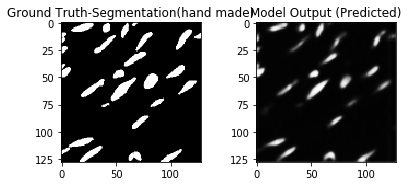

In [32]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
plt.title('Ground Truth-Segmentation(hand made)')
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")


ax = fig.add_subplot(1, 2, 2)
plt.title('Model Output (Predicted)')
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

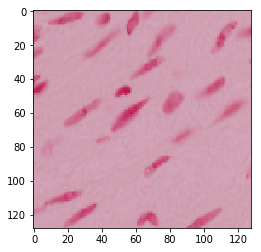

In [33]:
plt.imshow(x[0]) # above results for this input image

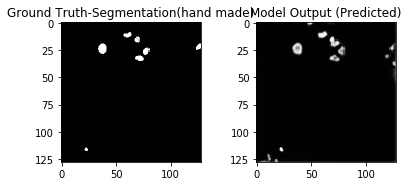

In [34]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
plt.title('Ground Truth-Segmentation(hand made)')
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
plt.title('Model Output (Predicted)')
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")

In [35]:
## Zomming in the above outputs

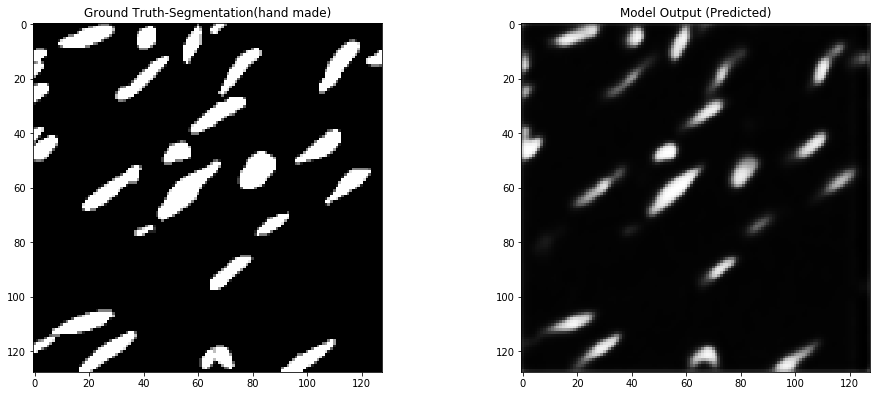

In [36]:
fig = plt.figure()
fig = plt.figure(figsize = (15,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
plt.title('Ground Truth-Segmentation(hand made)')
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")


ax = fig.add_subplot(1, 2, 2)
plt.title('Model Output (Predicted)')
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

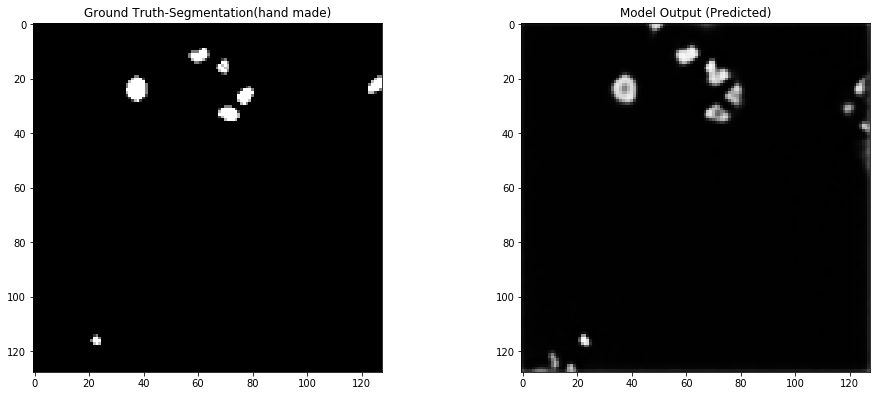

In [37]:
fig = plt.figure()
fig = plt.figure(figsize = (15,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
plt.title('Ground Truth-Segmentation(hand made)')
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
plt.title('Model Output (Predicted)')
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")